In [96]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [97]:
import pandas as pd
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [98]:
df = pd.read_csv('train.csv')
df_sub = pd.read_csv('test.csv')

In [99]:
df

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136424,136424,M22284,M,300.1,311.4,1530,37.5,210,0,0,0,0,0,0
136425,136425,H38017,H,297.5,308.5,1447,49.1,2,0,0,0,0,0,0
136426,136426,L54690,L,300.5,311.8,1524,38.5,214,0,0,0,0,0,0
136427,136427,L53876,L,301.7,310.9,1447,46.3,42,0,0,0,0,0,0


In [100]:
df.isnull().sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [101]:
df.drop(['id'], axis = 1, inplace=True)

# Data Overview

In [102]:
df.columns

Index(['Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

In [103]:
target = 'Machine failure'

failure_category = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

numeric = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
           'Torque [Nm]', 'Tool wear [min]']

categorical = ['Type', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

### Check the relation between Mahcine Failure and ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

In [104]:
df[(df[failure_category].sum(axis=1) == 0) & (df['Machine failure'] == 1)]

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
130,L52498,L,303.9,312.8,1345,56.5,21,1,0,0,0,0,0
228,M17895,M,300.7,309.7,1878,27.9,20,1,0,0,0,0,0
888,L50551,L,301.4,310.5,1359,51.2,196,1,0,0,0,0,0
1518,L48514,L,299.0,310.4,1536,49.1,15,1,0,0,0,0,0
1806,M19005,M,301.9,310.5,1543,34.6,86,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
134865,H35754,H,300.5,309.5,1397,45.9,17,1,0,0,0,0,0
134955,L54689,L,300.6,311.9,1515,35.9,212,1,0,0,0,0,0
135097,M22265,M,300.0,310.8,1359,52.1,163,1,0,0,0,0,0
135570,L54170,L,300.7,311.1,2478,41.1,170,1,0,0,0,0,0


In [105]:
df[(df[failure_category].sum(axis=1) != 0) & (df['Machine failure'] == 0)]

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
313,L49571,L,299.2,308.4,1447,46.6,145,0,0,0,0,0,1
1661,M20857,M,300.5,310.2,1761,26.2,228,0,0,0,0,0,1
1662,L54369,L,300.4,310.4,1634,33.7,48,0,0,0,0,0,1
2575,L49224,L,299.3,309.1,1470,41.1,118,0,0,0,0,0,1
2756,L48077,L,295.6,306.2,1612,31.2,59,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
134626,H37294,H,300.7,312.4,1457,47.2,74,0,0,0,0,0,1
134899,L53987,L,301.0,310.8,1549,41.4,121,0,0,0,0,0,1
134912,L56658,L,298.8,309.6,1552,40.1,173,0,0,0,0,0,1
135573,M20202,M,303.5,312.8,1375,45.7,89,0,0,0,0,0,1


In [106]:
df[(df[failure_category].sum(axis=1) != 0) & (df['RNF'] == 1) & (df['Machine failure'] == 1)]

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
23428,L55686,L,298.4,309.6,1710,27.3,163,1,0,0,0,0,1
78026,L53258,L,300.8,310.9,1339,59.1,203,1,0,0,0,1,1
101108,M15683,M,296.7,307.5,1356,54.2,153,1,0,0,1,0,1
102739,L50708,L,302.0,310.9,1415,53.1,212,1,1,0,0,0,1
108926,L51738,L,302.7,310.7,1397,47.6,11,1,0,1,0,0,1
124531,L51299,L,302.0,310.9,1360,45.2,12,1,0,1,0,0,1


In [107]:
df[numeric].describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
count,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000
mean,299.862776,309.941070,1520.331110,40.348643,104.408901
std,1.862247,1.385173,138.736632,8.502229,63.965040
min,295.300000,305.800000,1181.000000,3.800000,0.000000
25%,298.300000,308.700000,1432.000000,34.600000,48.000000
50%,300.000000,310.000000,1493.000000,40.400000,106.000000
75%,301.200000,310.900000,1580.000000,46.100000,159.000000
max,304.400000,313.800000,2886.000000,76.600000,253.000000


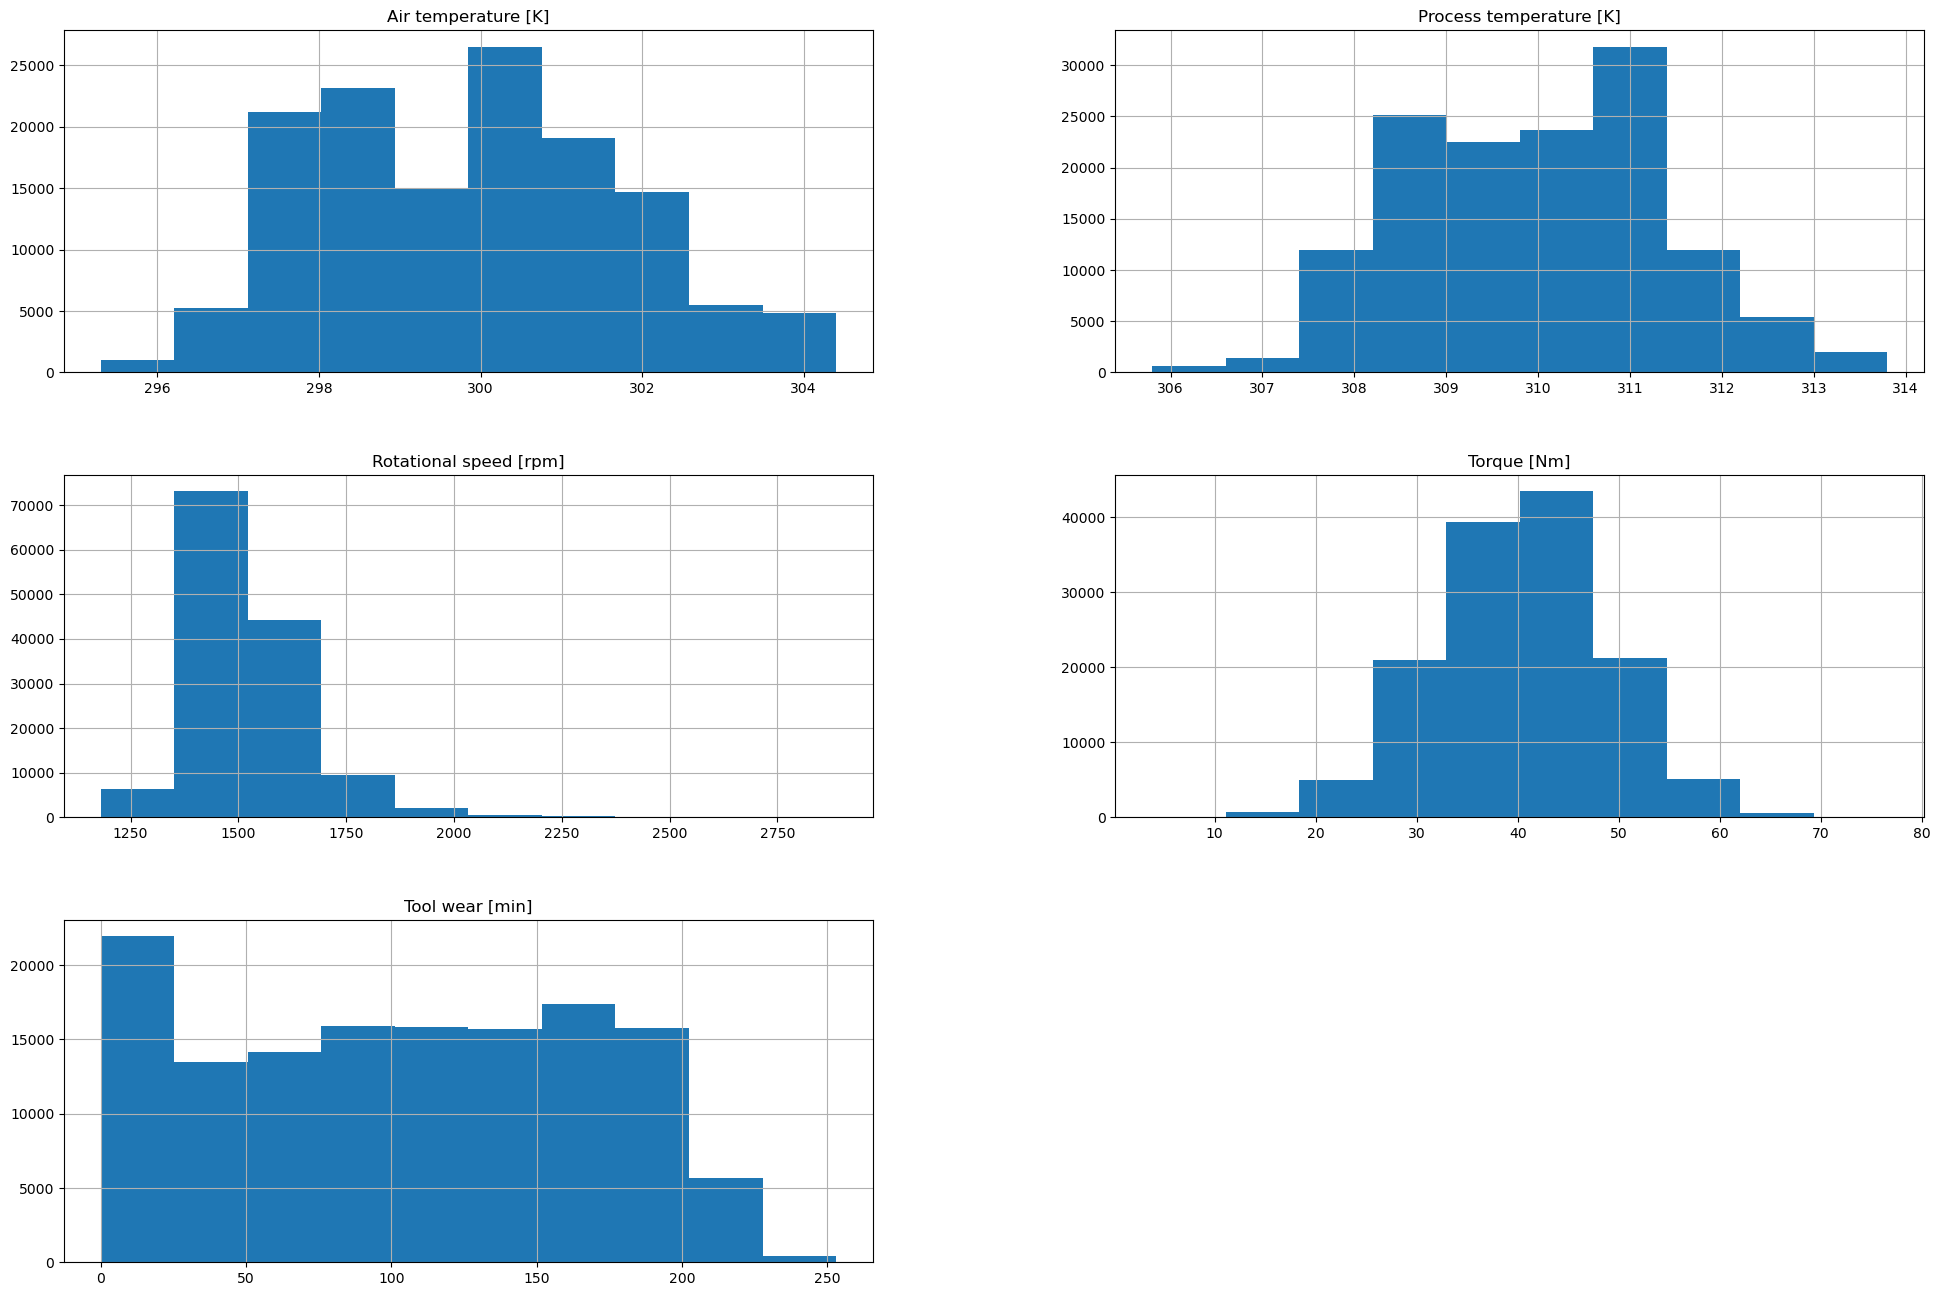

In [108]:
df[numeric].hist(figsize=(24,16))

plt.xlabel('X-axis Label', fontsize=12)
plt.ylabel('Y-axis Label', fontsize=12)

plt.show()

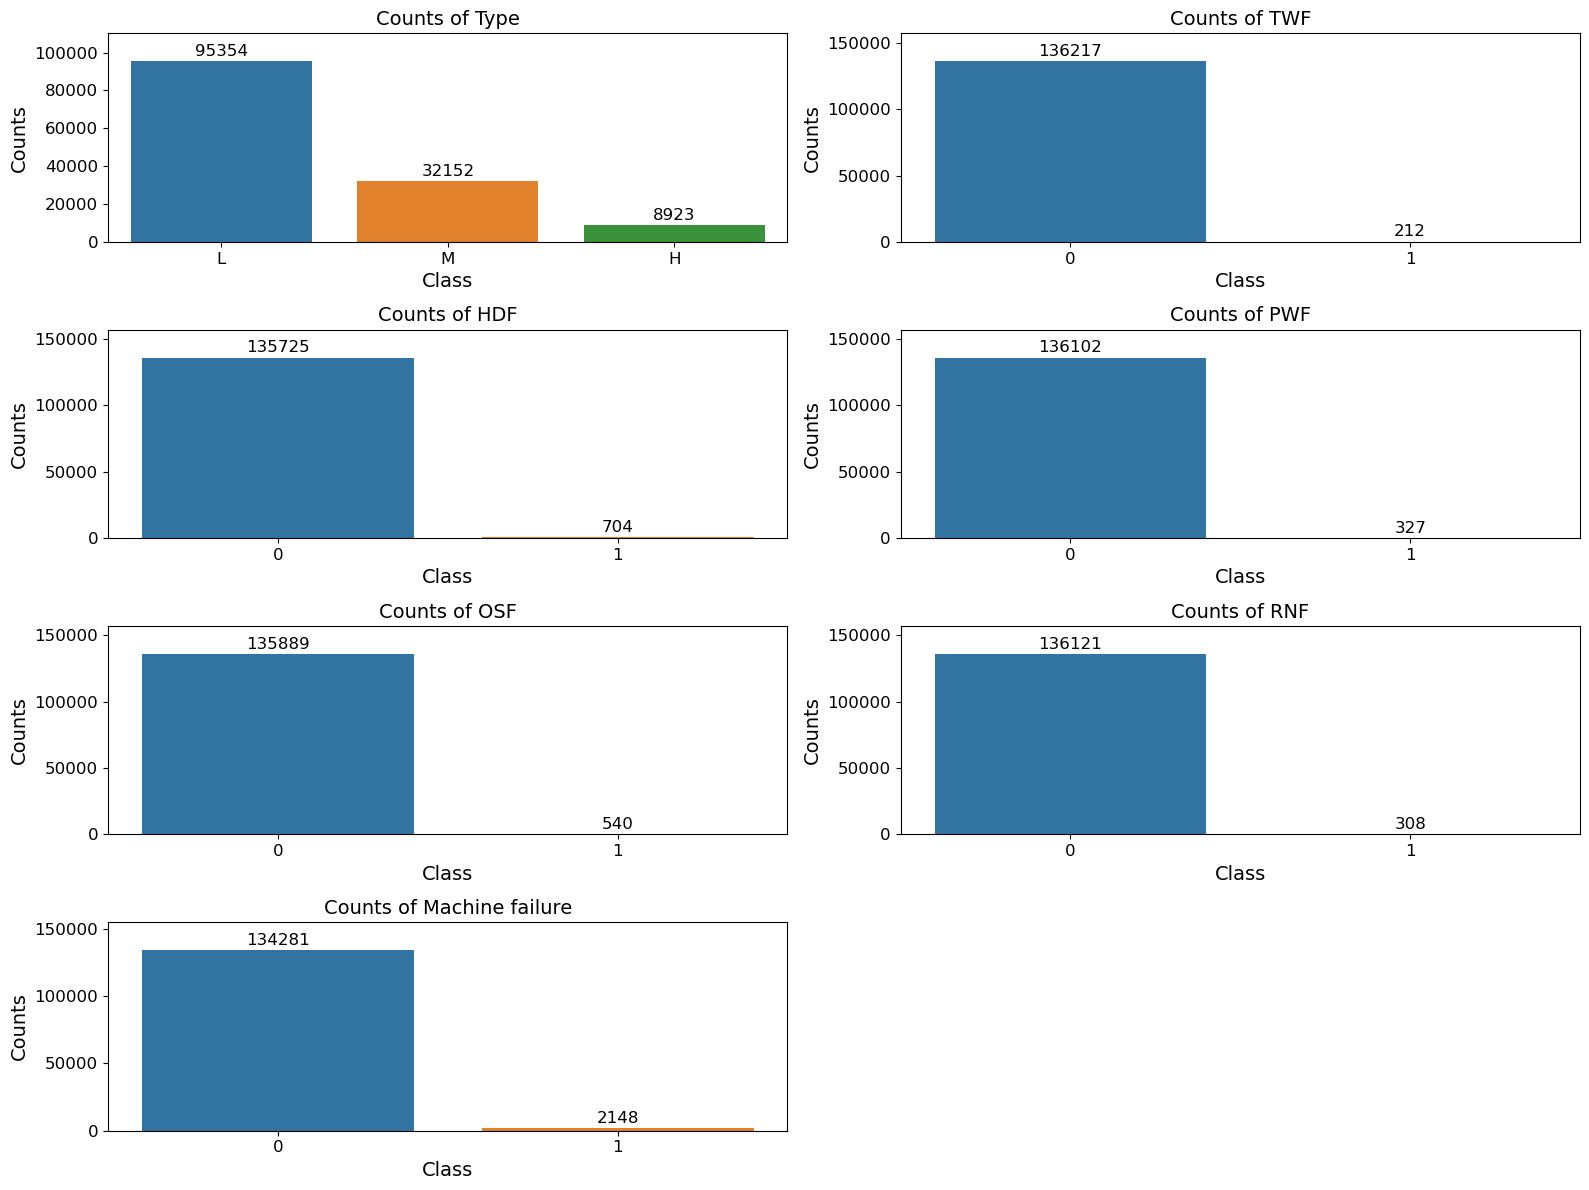

In [109]:
features = categorical + [target]

num_features = len(features)
num_rows = (num_features + 1) // 2  
num_cols = 2  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))

flattened_axes = axes.flatten()

for i, ax in enumerate(flattened_axes):
    if i < num_features:
        feature = features[i]
        sns.countplot(data=df, x=feature,  ax=ax)
        ax.set_xlabel('Class', fontsize=14)
        ax.set_ylabel('Counts', fontsize=14)
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.set_title(f'Counts of {feature}', fontsize=14)
        
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 7), textcoords='offset points', fontsize=12)
            
        ylim_top = ax.get_ylim()[1]
        ax.set_ylim(top=ylim_top * 1.1)
    else:
        ax.axis('off')  
        
plt.tight_layout()

plt.show()

## Plot Function

In [110]:
def plot_violin_distribution(df, features, target, num_cols):
    color = ['#F3DBD3', '#F5875F']

    num_rows = (len(features) + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    flattened_axes = axes.flatten()
    
    for i, ax in enumerate(flattened_axes):
        if i < num_features:
            
            sns.violinplot(x='Type', y=features[i], hue=target, split=True, data=df, ax=ax, palette=color)
            
            ax.set_xlabel('Type', fontsize=14)
            ax.set_ylabel(f'{features[i]}', fontsize=14)
            ax.tick_params(axis='x', labelsize=12)
            ax.tick_params(axis='y', labelsize=12)
            
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()    

In [111]:
def plot_kde_distribution(df, features, target, num_cols):

    num_rows = (len(features) + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    flattened_axes = axes.flatten()


    for i, ax in enumerate(flattened_axes):
        if i < len(features):
        
            sns.kdeplot(data=df[df[target] == 0], x=features[i], fill=True, linewidth=2, ax=ax, label='0', color='#F3DBD3')
            sns.kdeplot(data=df[df[target] == 1], x=features[i], fill=True, linewidth=2, ax=ax, label='1', color='#F5875F')

            ax.set_yticks([])
            ax.legend(title=target, loc='upper right')
        else:
            ax.axis('off')


    plt.suptitle('Feature Distributions vs Target', fontsize=22, y=1.02)
    plt.tight_layout()
    plt.show()

In [112]:
def plot_single_kde(df, feature, target):
    
    plt.figure(figsize=(15,8))
    
    sns.kdeplot(data=df[df[target] == 0], x=feature, fill=True, linewidth=2, label='0', color='#F3DBD3')
    sns.kdeplot(data=df[df[target] == 1], x=feature, fill=True, linewidth=2, label='1', color='#F5875F')
    plt.yticks([])
    plt.legend(title=target, loc='upper right')
    plt.title(f'KDE Distribution of {feature} by {target}')
    plt.show()

In [113]:
def count_outliers(df, column_name, percent_1=0.25, percent_2=0.75):
    Q1 = df[column_name].quantile(percent_1)
    Q3 = df[column_name].quantile(percent_2)
    IQR = Q3 - Q1

    outlier_condition = ((df[column_name] < (Q1 - 1.5 * IQR)) | (df[column_name] > (Q3 + 1.5 * IQR))) 

    return outlier_condition.sum()

def range_outliers(df, column_name, percent_1=0.25, percent_2=0.75):
    Q1 = df[column_name].quantile(percent_1)
    Q3 = df[column_name].quantile(percent_2)
    IQR = Q3 - Q1
    
    return (Q1, IQR, Q3)

def remove_outliers(df, column_name, percent_1=0.25, percent_2=0.75):
    Q1, IQR, Q3 = range_outliers(df, column_name, percent_1, percent_2)
    
    keep_condition = ((df[column_name] >= (Q1 - 1.5 * IQR)) & (df[column_name] <= (Q3 + 1.5 * IQR)))
    
    return df[keep_condition]

# Data Split

We began by examining the proportion of failed machines relative to the entire set of machines. Evidently, only a small fraction (1.6%) represented machine failures. Given this imbalance, it's essential to employ stratified sampling when splitting the data into training and test sets

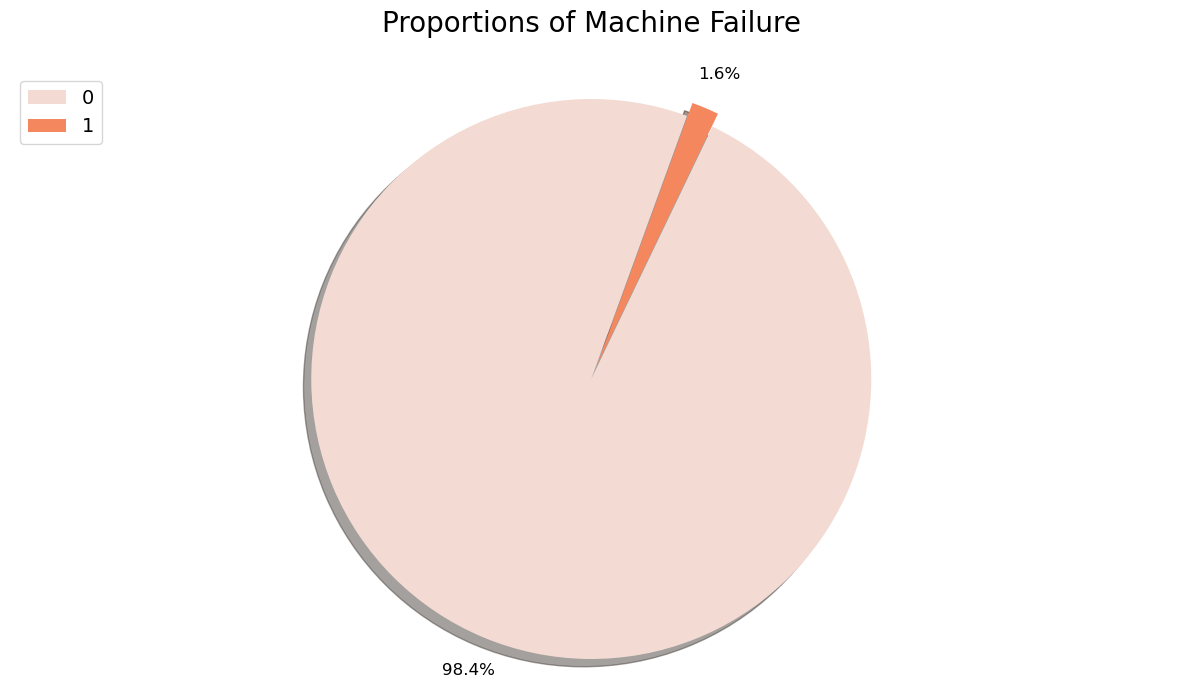

In [114]:
target_proportions = df[target].value_counts() / len(df)

color = ['#F3DBD3', '#F5875F']
labels = target_proportions.index.tolist()
sizes = target_proportions.values.tolist()
explode = [0, 0.05]

plt.figure(figsize=(15,8))
plt.pie(sizes, labels = None, autopct='%1.1f%%', startangle=70,
        shadow=True, pctdistance=1.13, explode=explode, colors=color, textprops={'fontsize': 12})

plt.title('Proportions of Machine Failure', y=1.05, fontsize=20)
plt.legend(labels = labels, loc='upper left', fontsize=14)
plt.axis('equal')

plt.show()

In [115]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df[target], random_state=42)

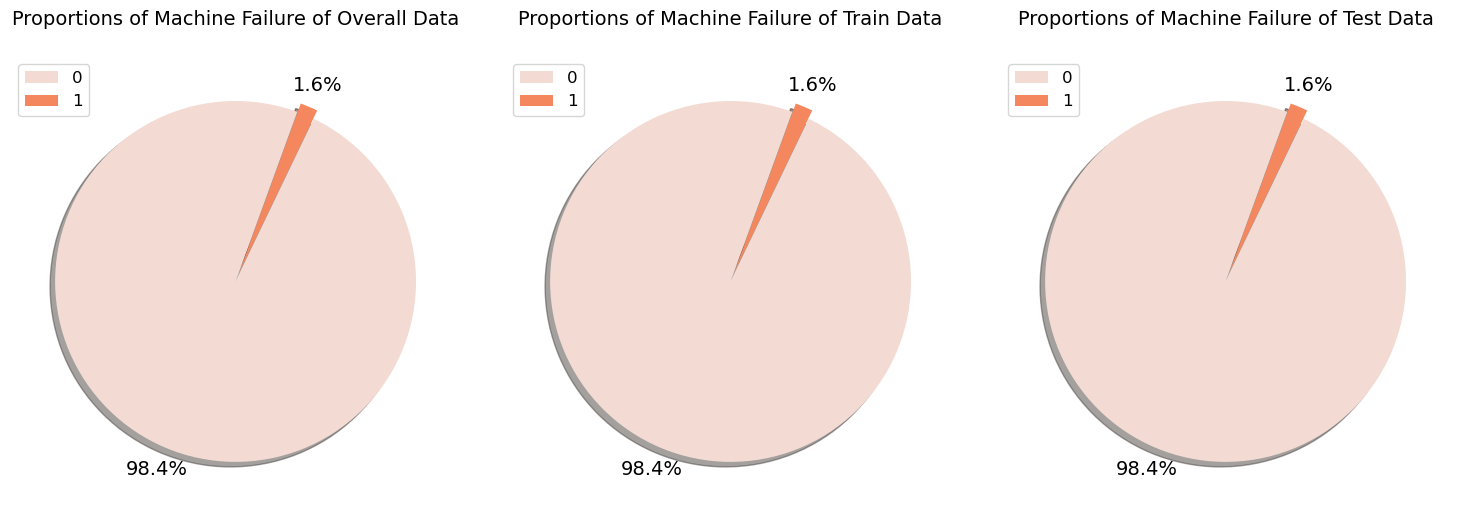

In [116]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

flattened_axes = axes.flatten()

color = ['#F3DBD3', '#F5875F']
display = ['Overall', 'Train', 'Test']
dataSet = [df, df_train, df_test]
explode = [0, 0.05]

target_proportions = df[target].value_counts() / len(df)
labels = target_proportions.index.tolist()
sizes = target_proportions.values.tolist()

for i, ax in enumerate(flattened_axes):
    
    data = dataSet[i]
    target_proportions = data[target].value_counts() / len(data)
    labels = target_proportions.index.tolist()
    sizes = target_proportions.values.tolist()
    
    ax.pie(sizes, labels = None, autopct='%1.1f%%', startangle=70,
        shadow=True, pctdistance=1.13, explode=explode, colors=color, textprops={'fontsize': 14})
    
    ax.set_title(f'Proportions of Machine Failure of {display[i]} Data', y=1.05, fontsize=14)
    ax.legend(labels = labels, loc='upper left', fontsize=12)
    
plt.tight_layout()

plt.show()

# EDA

## Machine Type

We have three distinct machine types: L, M, and H. On examining the distribution of these machine types, it becomes evident that machines of type L constitute the majority.

Furthermore, we delved into understanding the failure rate associated with each machine type. The analysis revealed that type L machines exhibit the highest failure ratio. However, the differences in failure rates among the machine types are marginal, all within a 10% range. Given this small variation, we can infer that the machine type doesn't play a significant role in influencing machine failures.

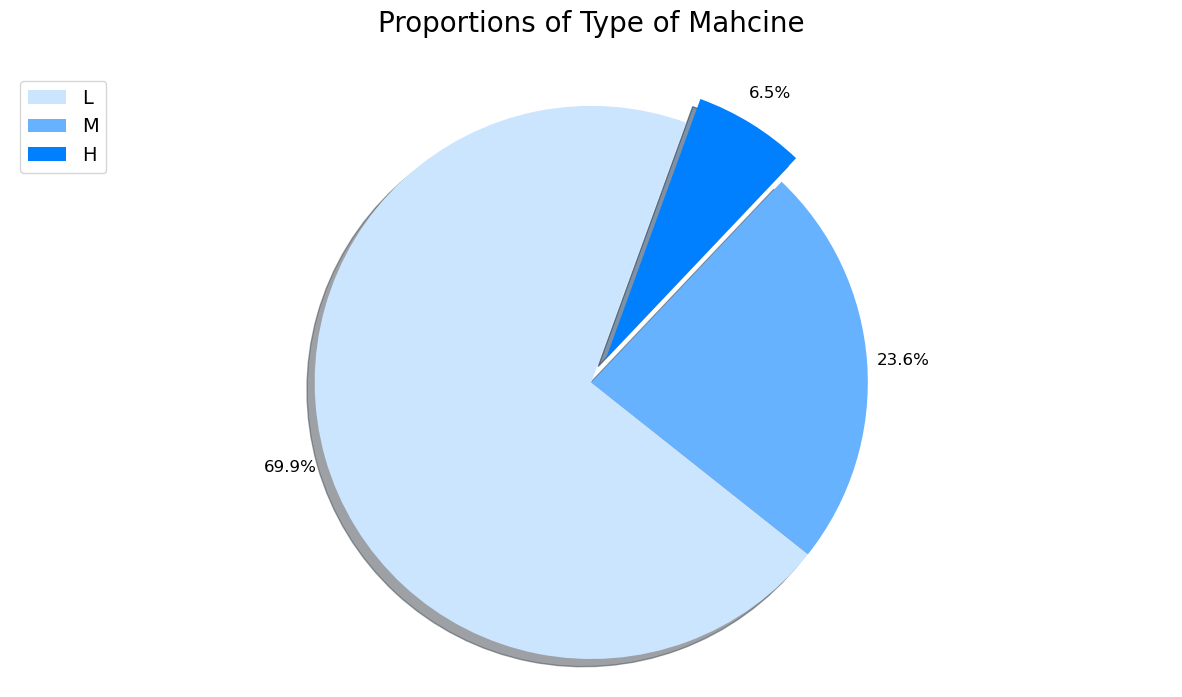

In [117]:
type_proportions = df_train['Type'].value_counts() / len(df_train)

labels = type_proportions.index.tolist()
sizes = type_proportions.values.tolist()

color_palette = {'L': '#CCE5FF', 'M': '#66B2FF', 'H': '#0080FF'}
colors = [color_palette[label] for label in labels]

explode = [0, 0, 0.1]

plt.figure(figsize=(15,8))

plt.pie(sizes, labels = None, autopct='%1.1f%%', startangle=70,
        shadow=True, pctdistance=1.13, explode=explode, textprops={'fontsize': 12}, colors=colors)

plt.title('Proportions of Type of Mahcine', y=1.05, fontsize=20)
plt.legend(labels = labels, loc='upper left', fontsize=14)
plt.axis('equal')

plt.show()

In [118]:
labels

['L', 'M', 'H']

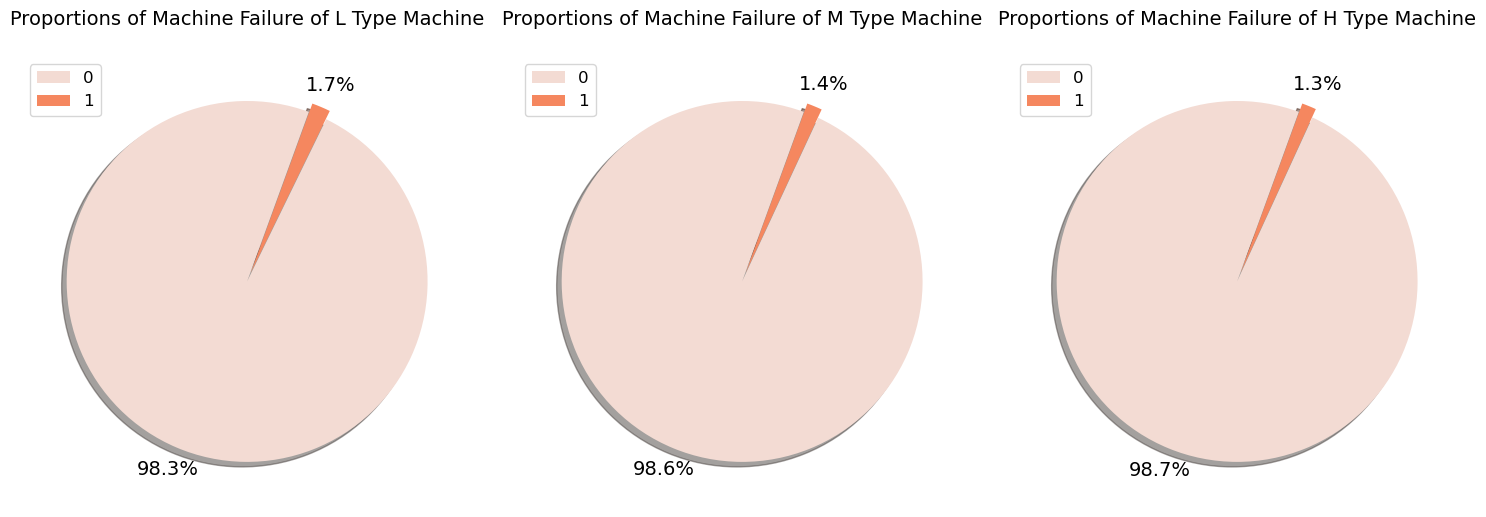

In [119]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

flattened_axes = axes.flatten()

color = ['#F3DBD3', '#F5875F']
Type = ['L', 'M', 'H']
explode = [0, 0.05]

for i, ax in enumerate(flattened_axes):
    
    mask = (df_train['Type'] == Type[i])
    
    data = df_train[mask]
    
    target_proportions = data[target].value_counts() / len(data)
    labels = target_proportions.index.tolist()
    sizes = target_proportions.values.tolist()
    
    ax.pie(sizes, labels = None, autopct='%1.1f%%', startangle=70,
        shadow=True, pctdistance=1.13, explode=explode, colors=color, textprops={'fontsize': 14})
    
    ax.set_title(f'Proportions of Machine Failure of {Type[i]} Type Machine', y=1.05, fontsize=14)
    ax.legend(labels = labels, loc='upper left', fontsize=12)
    
plt.tight_layout()

plt.show()

## Failure Mode

Let's now delve into the proportions of failed machines across different types of failure modes: TWF, HDF, PWF, OSF, and RNF.

From our analysis, it's apparent that machines with failure modes HDF, OSF, or PWF exhibit a higher likelihood of failure.

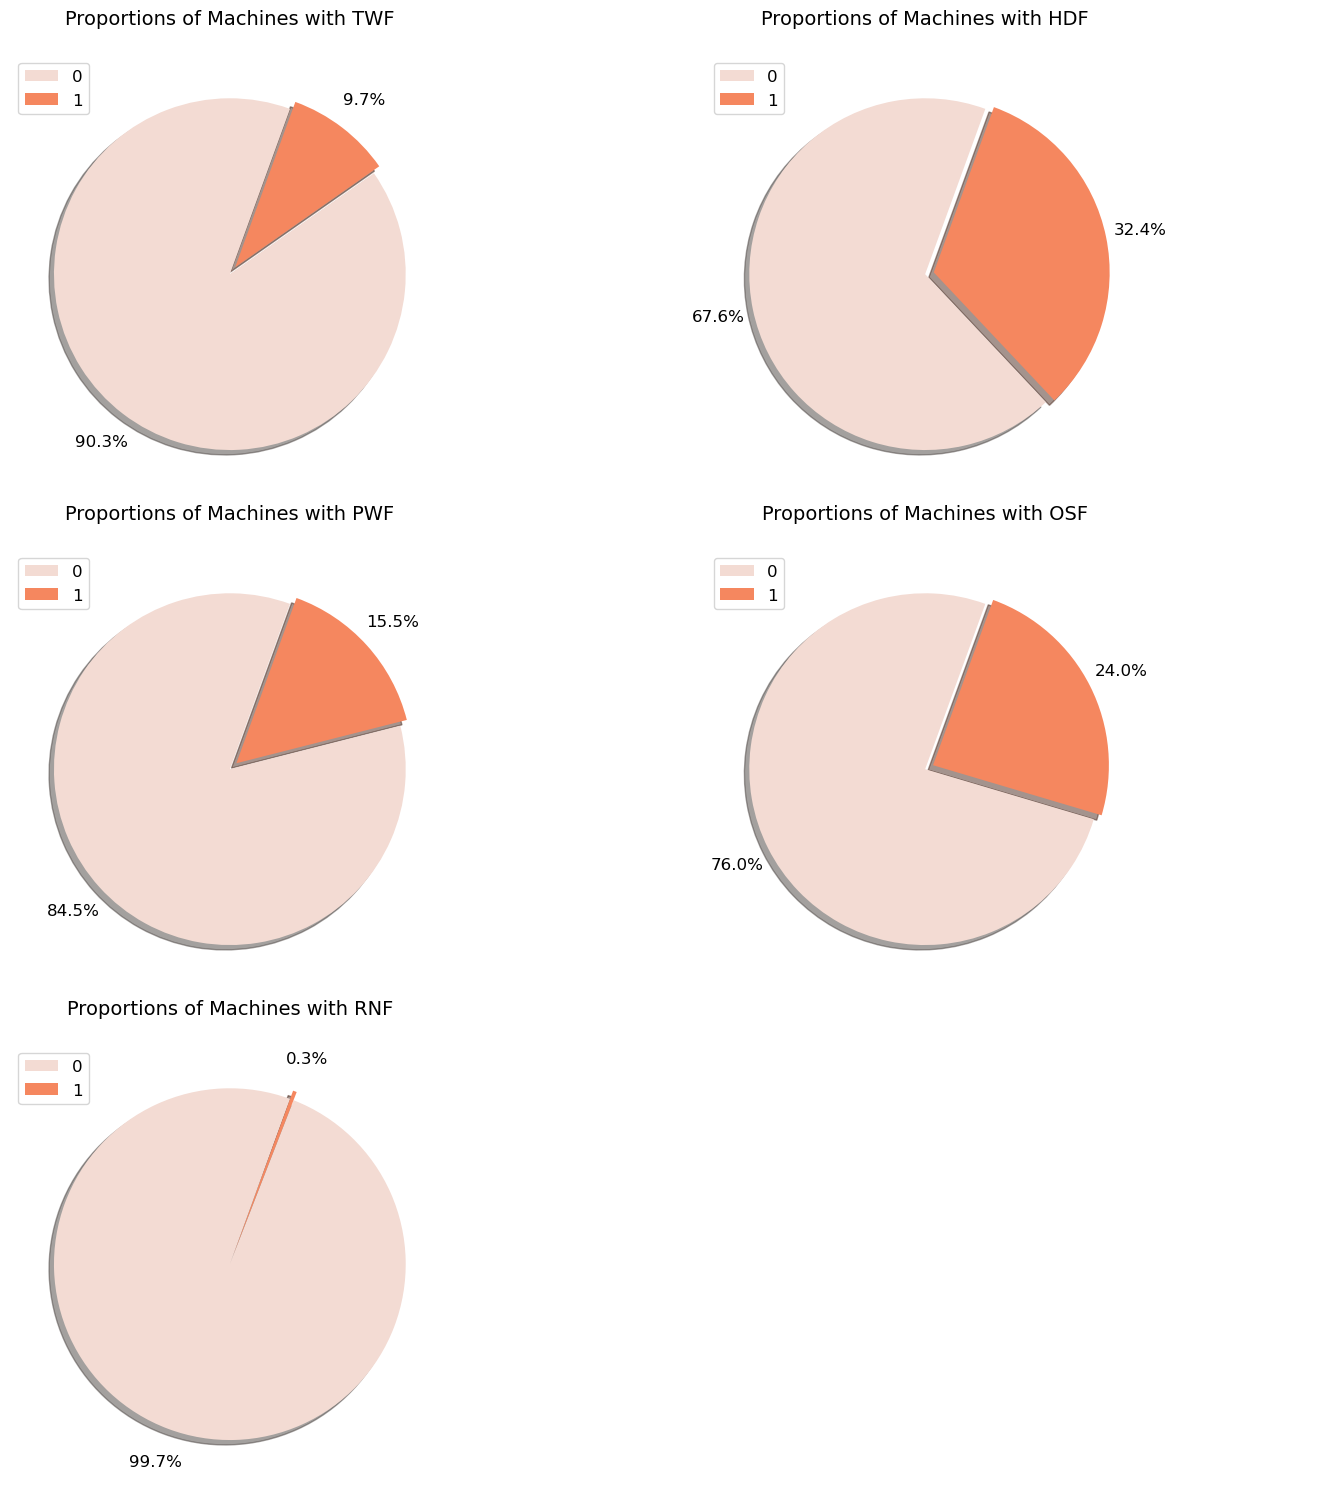

In [120]:
num_features = len(failure_category)
num_rows = (num_features + 1) // 2  
num_cols = 2  

color = ['#F3DBD3', '#F5875F']
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15,15))

flattened_axes = axes.flatten()

data = df_train[df_train['Machine failure'] == 1]

explode = [0, 0.05]

for i, ax in enumerate(flattened_axes):
    if i < num_features:

        target_proportions = data[failure_category[i]].value_counts() / len(data)
        labels = target_proportions.index.tolist()
        sizes = target_proportions.values.tolist()

        ax.pie(sizes, labels = None, autopct='%1.1f%%', startangle=70,
            shadow=True, pctdistance=1.2, explode=explode, colors=color, textprops={'fontsize': 12})

        ax.set_title(f'Proportions of Machines with {failure_category[i]}', y=1.05, fontsize=14)
        ax.legend(labels = labels, loc='upper left', fontsize=12)
    else:
        ax.axis('off')

plt.tight_layout()

plt.show()

## Numeric Features

Let's now examine the histogram and boxplot of our numeric features, categorized by machine type. From both the histogram and boxplot, it's evident that the distributions across the three different machine types are nearly identical. This observation reinforces our earlier conclusion that the type of machine doesn't significantly influence the probability of machine failure. Additionally, the distributions of all numeric features closely resemble a normal distribution, which is favorable. There isn't a pronounced skewness in the data. However, outliers in the "Rotational speed" and "Torque" features are noticeable and warrant attention in subsequent stages of our analysis.



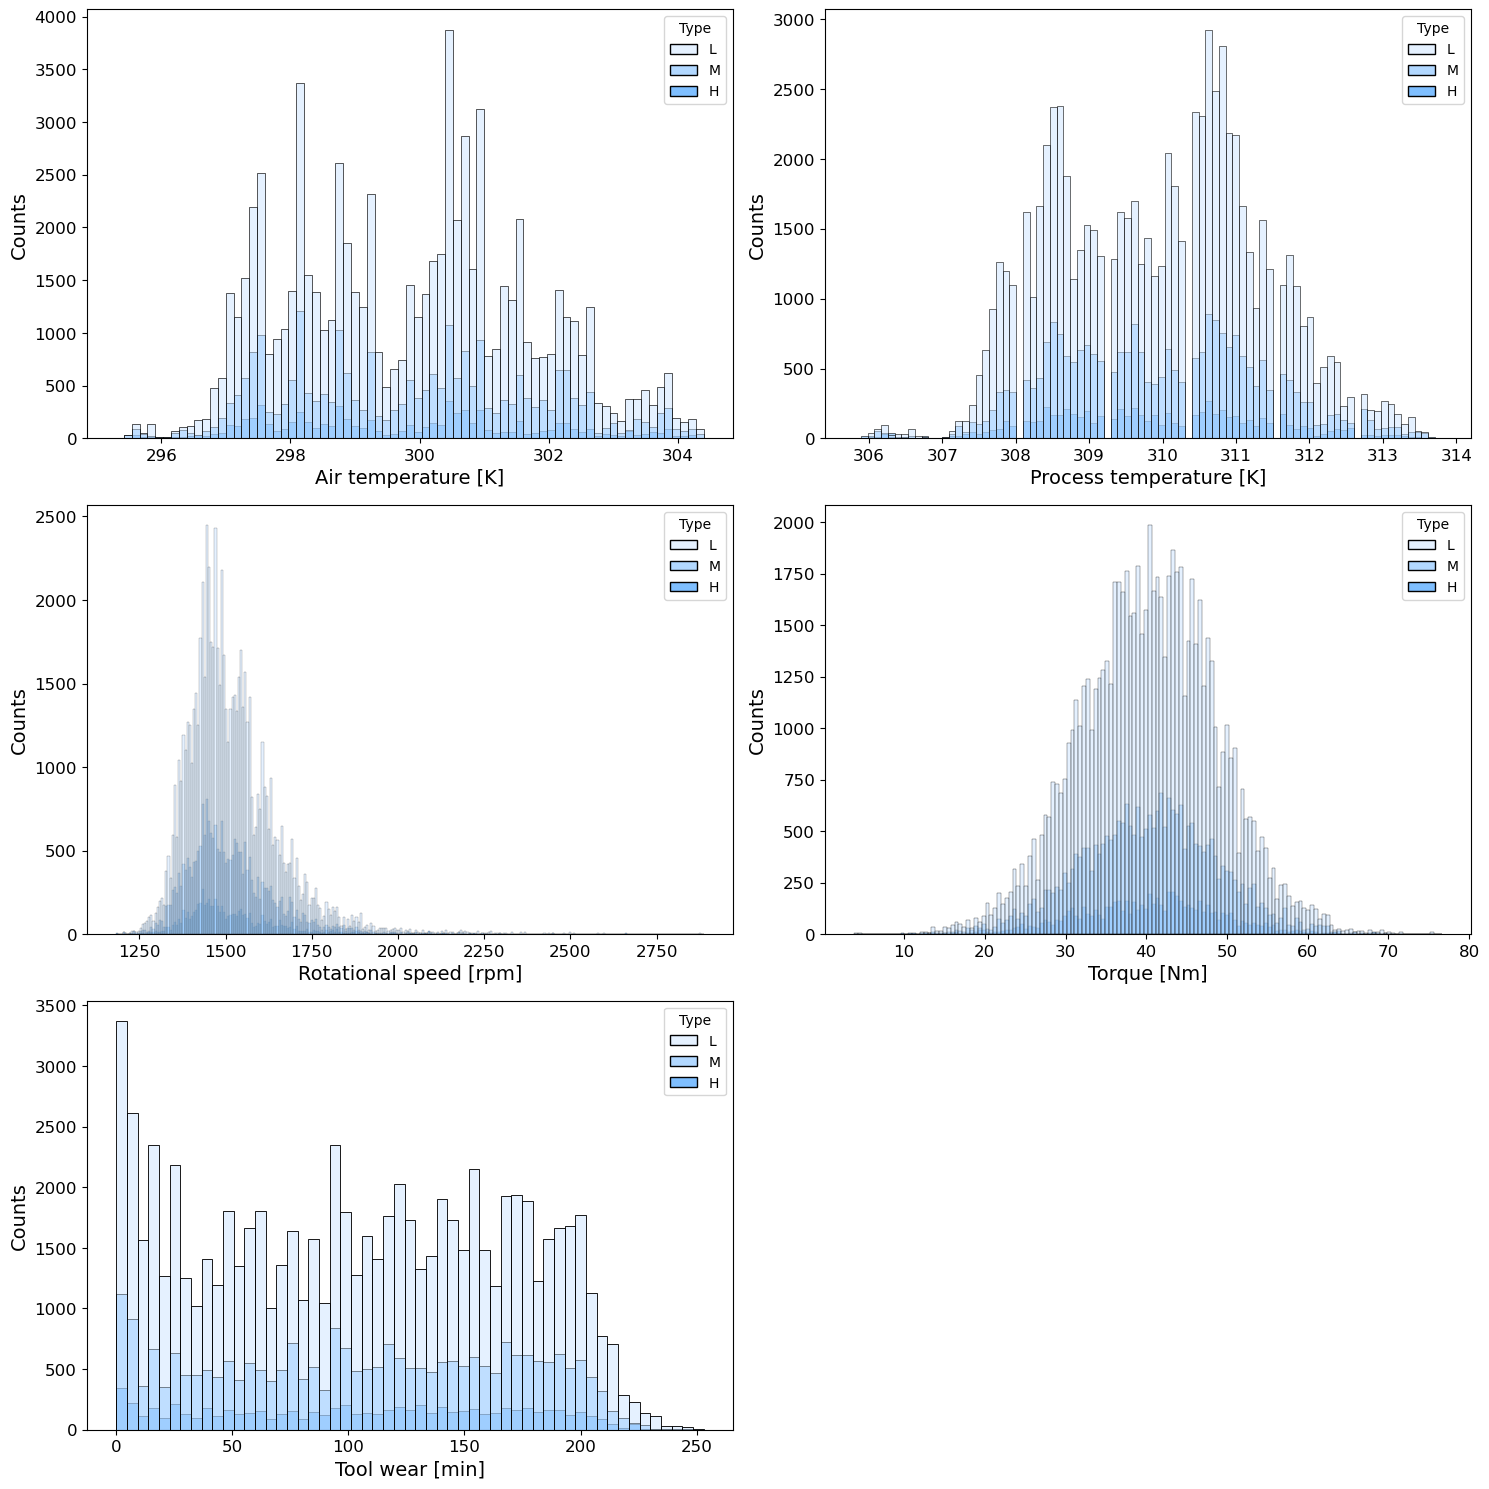

In [121]:
num_features = len(numeric)
num_rows = (num_features + 1) // 2  
num_cols = 2  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

flattened_axes = axes.flatten()

desired_order = ['L', 'M', 'H']

for i, ax in enumerate(flattened_axes):
    
    if i < num_features:
        feature = numeric[i]
        sns.histplot(data=df_train, x=feature, kde=False, hue='Type', hue_order=desired_order, ax=ax, palette=color_palette)
        ax.set_xlabel(f'{feature}', fontsize=14)
        ax.set_ylabel('Counts', fontsize=14)
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)

    else:
        ax.axis('off')
    
plt.tight_layout()
plt.show()

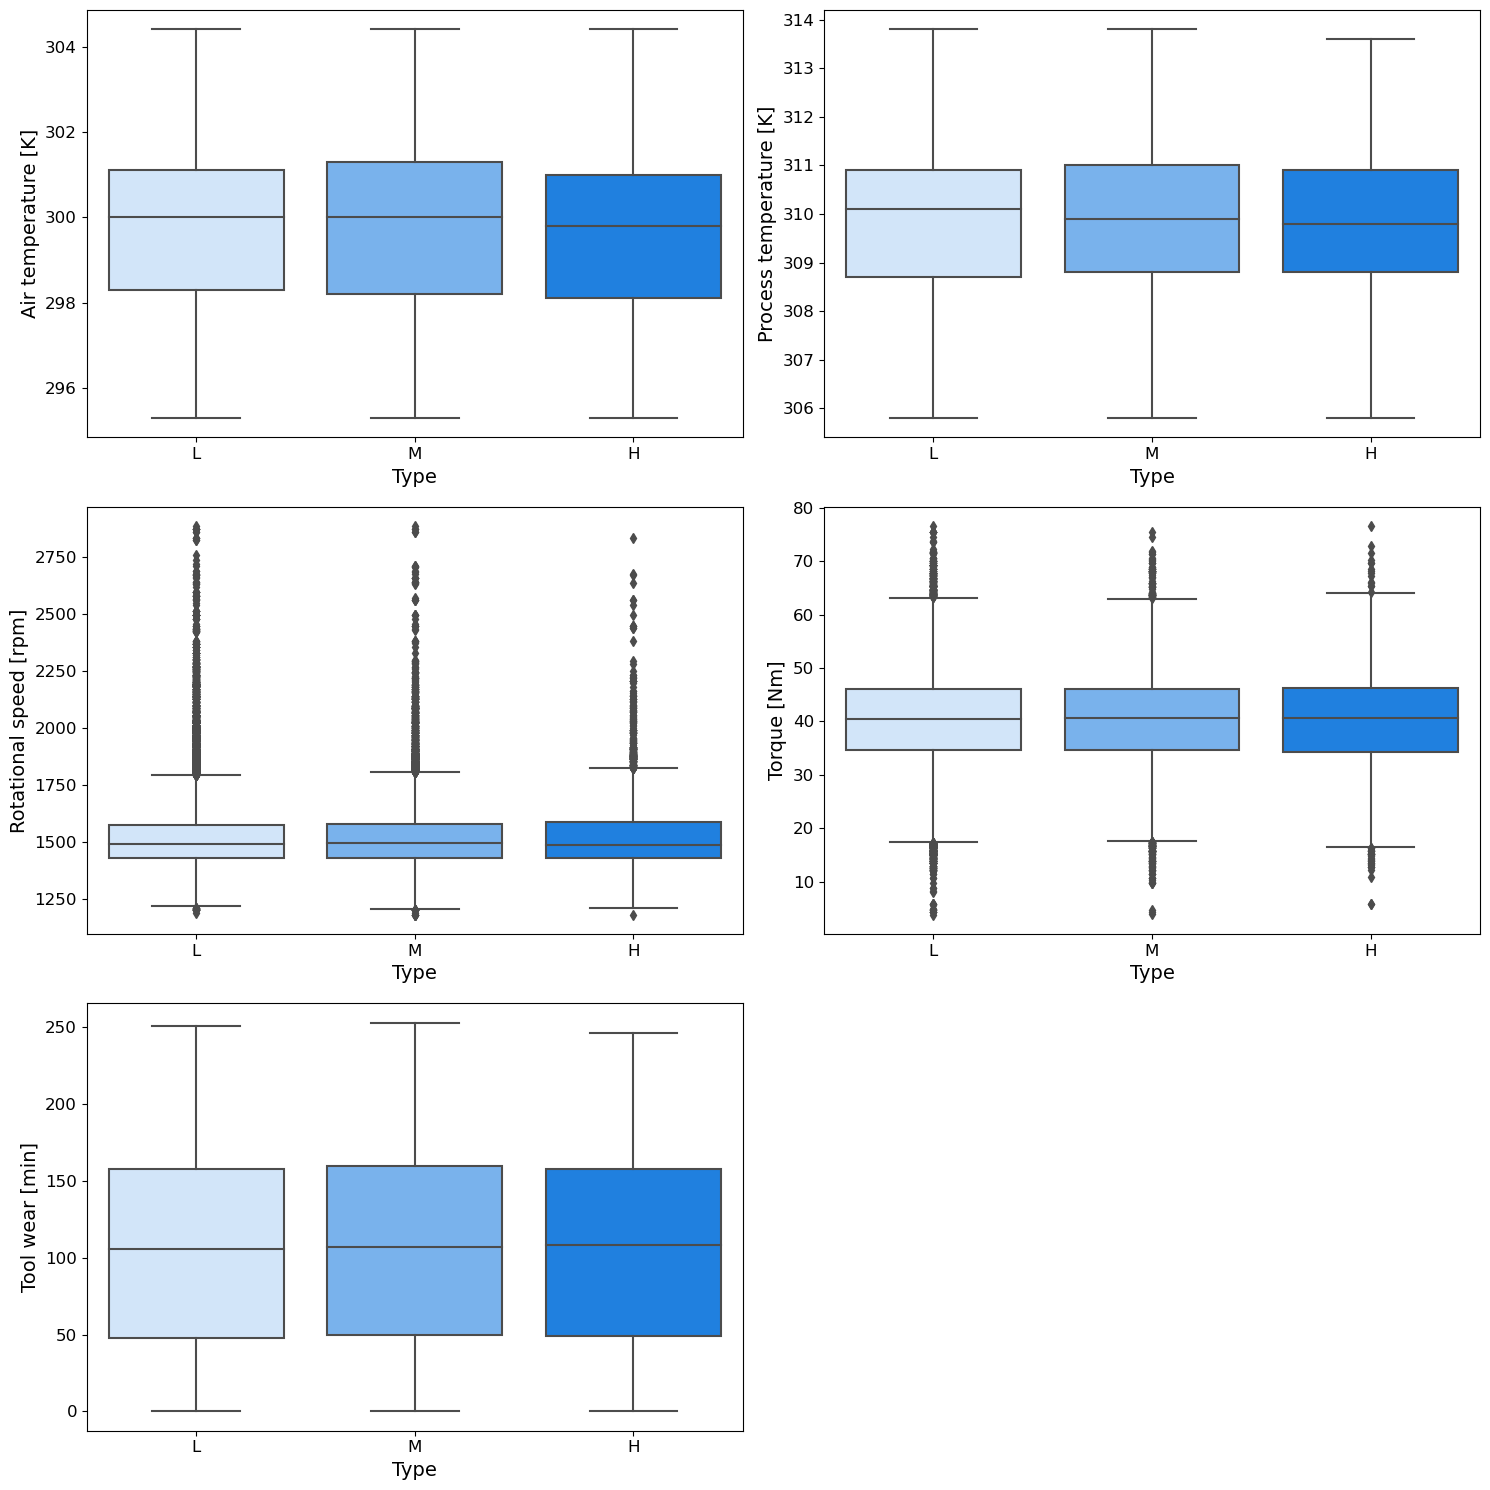

In [122]:
num_features = len(numeric)
num_rows = (num_features + 1) // 2  
num_cols = 2  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

flattened_axes = axes.flatten()

for i, ax in enumerate(flattened_axes):
    if i < num_features:
        sns.boxplot(x='Type', y=numeric[i], data=df_train, ax=ax, palette=color_palette, order=desired_order)
        
        ax.set_xlabel('Type', fontsize=14)
        ax.set_ylabel(f'{numeric[i]}', fontsize=14)
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        
    else:
        ax.axis('off')
        
plt.tight_layout()
plt.show()

Now, let's take a brief look at the violin plots for all numeric features, segregated by machine type, with an emphasis on our machine failure target.

The violin plots highlight the range of values where there is a higher density for both target classes: 0 and 1.

From the plots, the distribution patterns across different machine types don't show vast differences. However, it's noteworthy that the distributions of the targets within the "Rotational speed", "Air temperature", and "Torque" features differ substantially. This is a promising observation as these features might significantly influence machine failure.

That said, it's crucial not to dismiss other features as being unimportant. We have yet to explore potential interactions between these features, which could also play a pivotal role in determining machine failure.



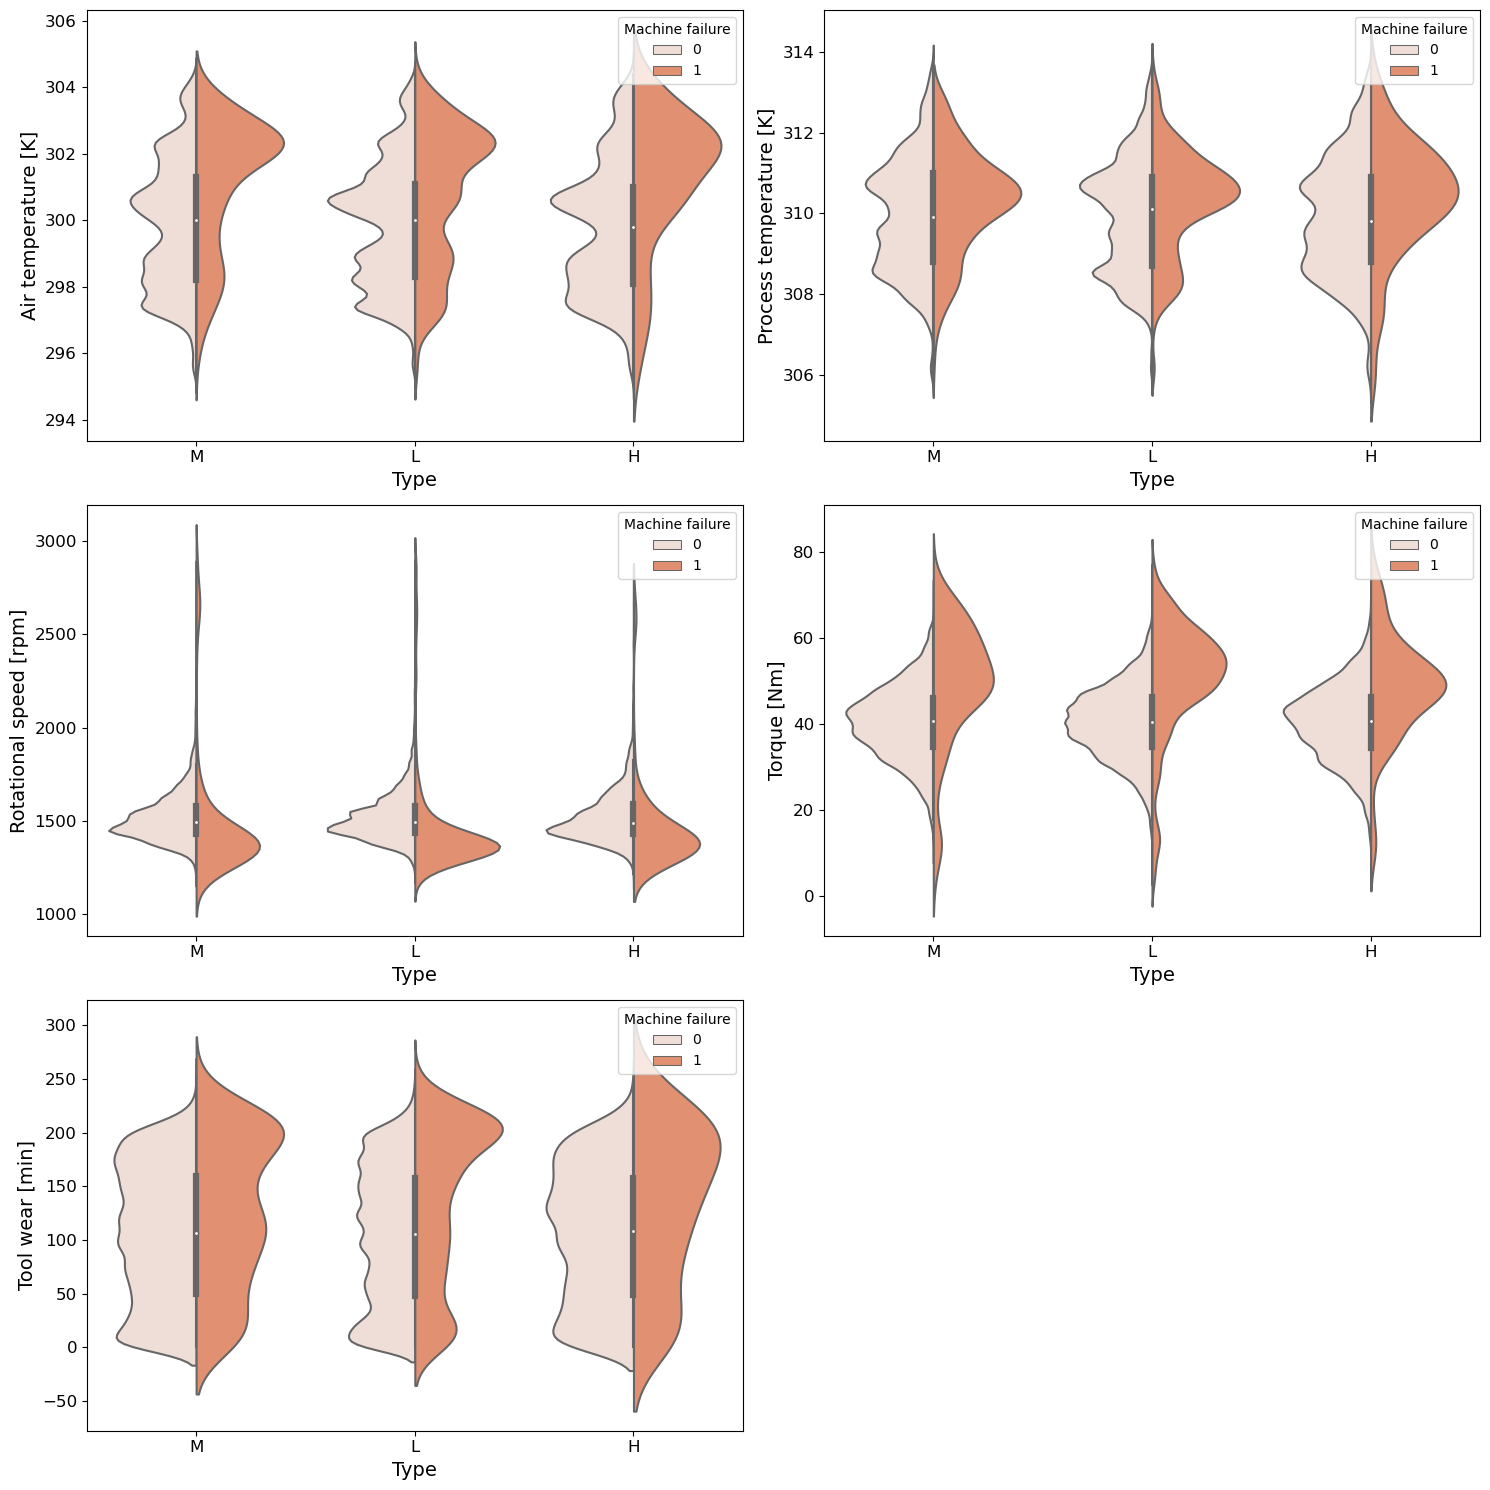

In [123]:
plot_violin_distribution(df_train, numeric, 'Machine failure', 2)        

Based on our prior analyses, machine type doesn't seem to have a significant impact on machine failure. Given this insight, we will shift our focus to analyzing features based on all machines collectively, rather than segmenting by type.

# Correlation

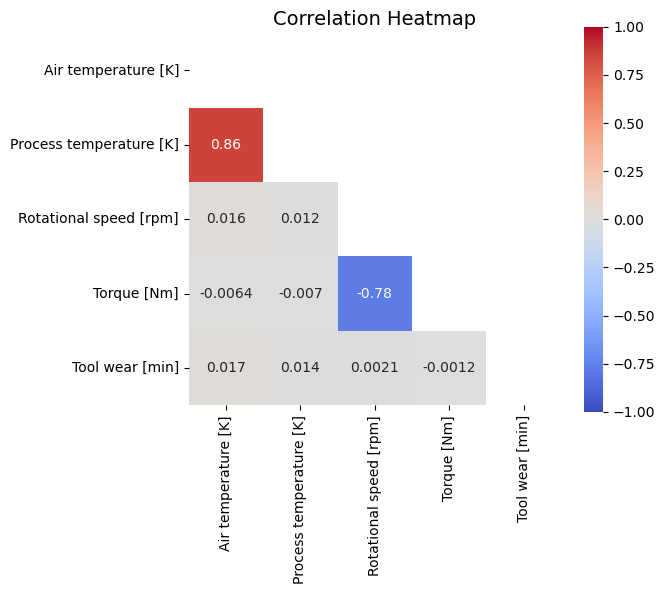

In [124]:
plt.figure(figsize=(6, 5))
mask = np.triu(np.ones_like(df_train[numeric].corr(), dtype=bool))
sns.heatmap(df_train[numeric].corr(), annot=True, square=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask)

plt.title('Correlation Heatmap',size=14)
plt.show()

## Failure Mode Analysis

Based on our analysis of pie charts representing proportions of machines with various failure modes, it is evident that machines with HDF, OSF, or PWF exhibit the highest failure rates. Consequently, our primary focus will be on analyzing these three failure modes.

### Tool Wear Failure

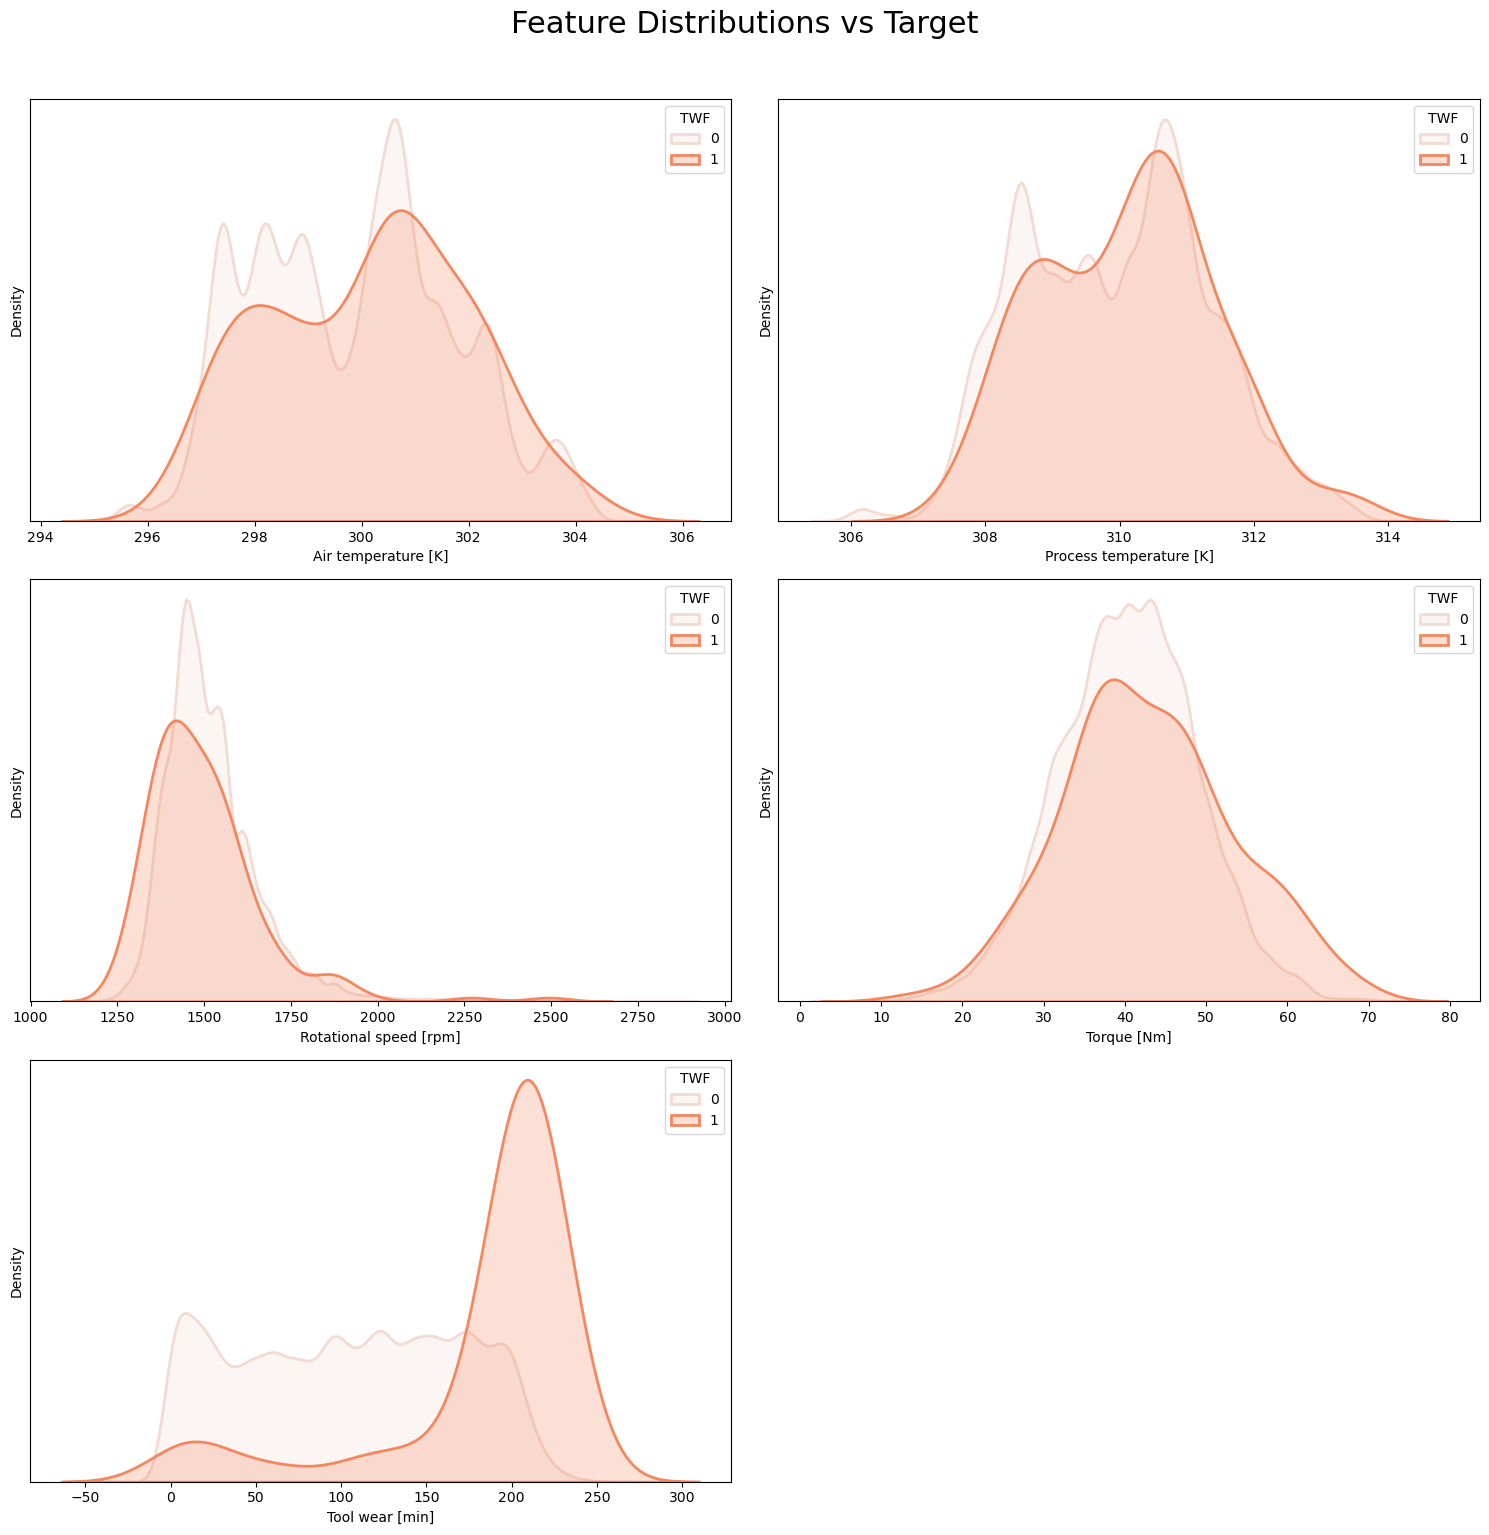

In [125]:
plot_kde_distribution(df_train, numeric, 'TWF', 2)

From the KDE plot, it is clear that the primary feature influencing TWF is 'Tool wear [min]'. This observation is also consistent with what one might reasonably expect.

### Heat Dissipation Failure

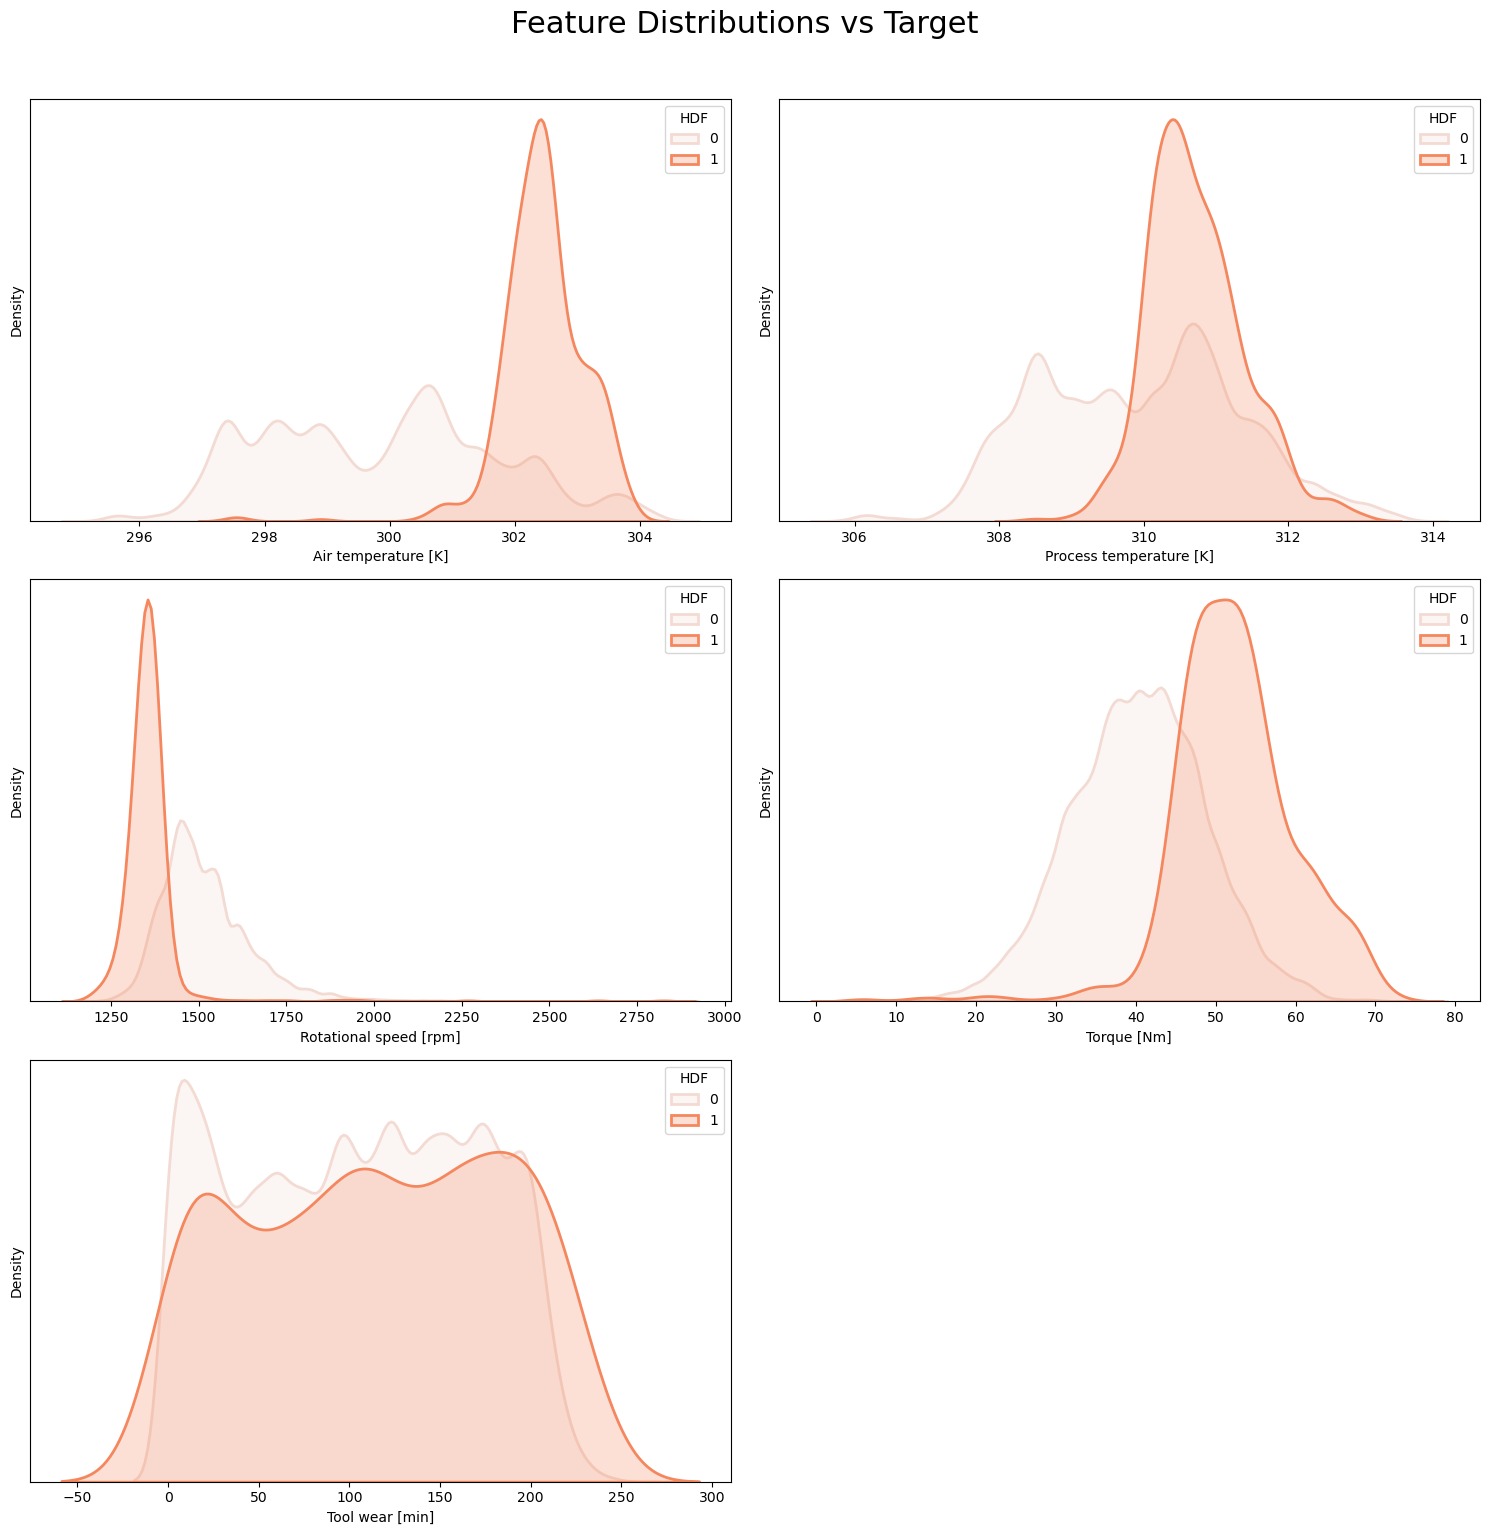

In [126]:
plot_kde_distribution(df_train, numeric, 'HDF', 2)

From the KDE plot, it's evident that the primary features impacting HDF are 'Air temperature [K]' and 'Process temperature [K]'. Drawing upon thermodynamics, the main factor influencing heat dissipation is typically the difference between system temperature and environmental temperature. Consequently, I've introduced a new feature, 'Temperature difference [K]', to investigate if it serves as a primary determinant for HDF.

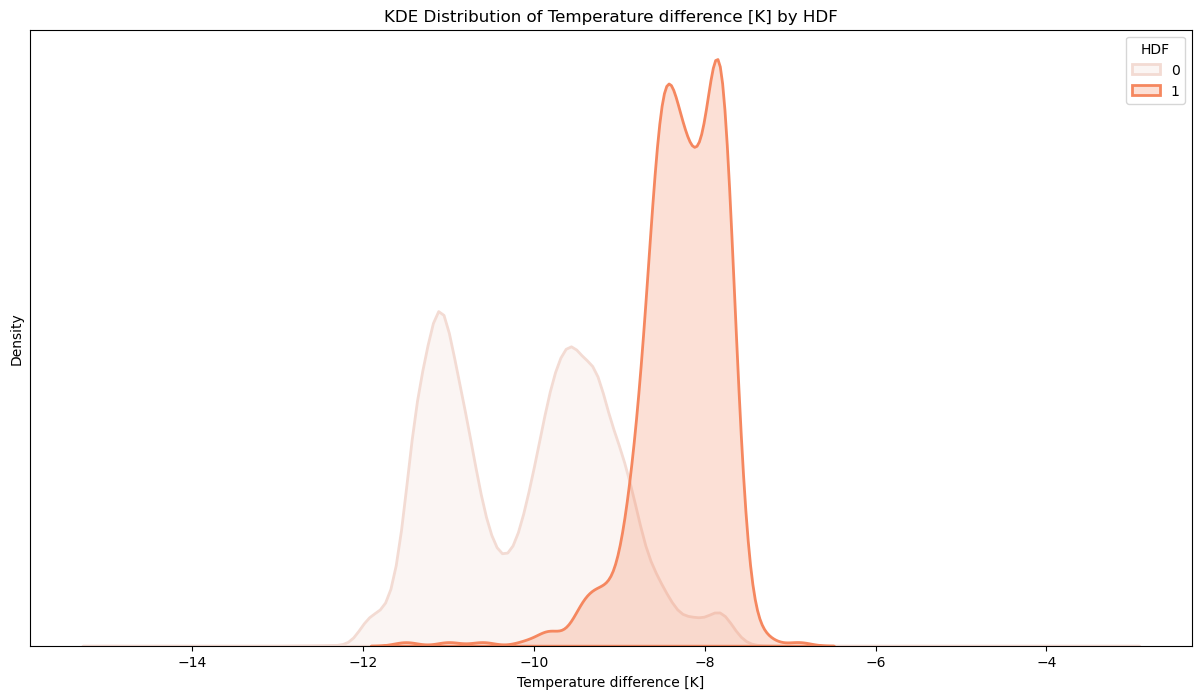

In [127]:
df_train['Temperature difference [K]'] = (df_train['Air temperature [K]'] - df_train['Process temperature [K]'])
df_test['Temperature difference [K]'] = (df_test['Air temperature [K]'] - df_test['Process temperature [K]'])
df_sub['Temperature difference [K]'] = (df_sub['Air temperature [K]'] - df_sub['Process temperature [K]'])

plot_single_kde(df_train, 'Temperature difference [K]', 'HDF')

It's evident from the KDE distribution that the new feature significantly differentiates between machines with HDF and those without. Thus, our speculation appears to be accurate.

### Power Failure

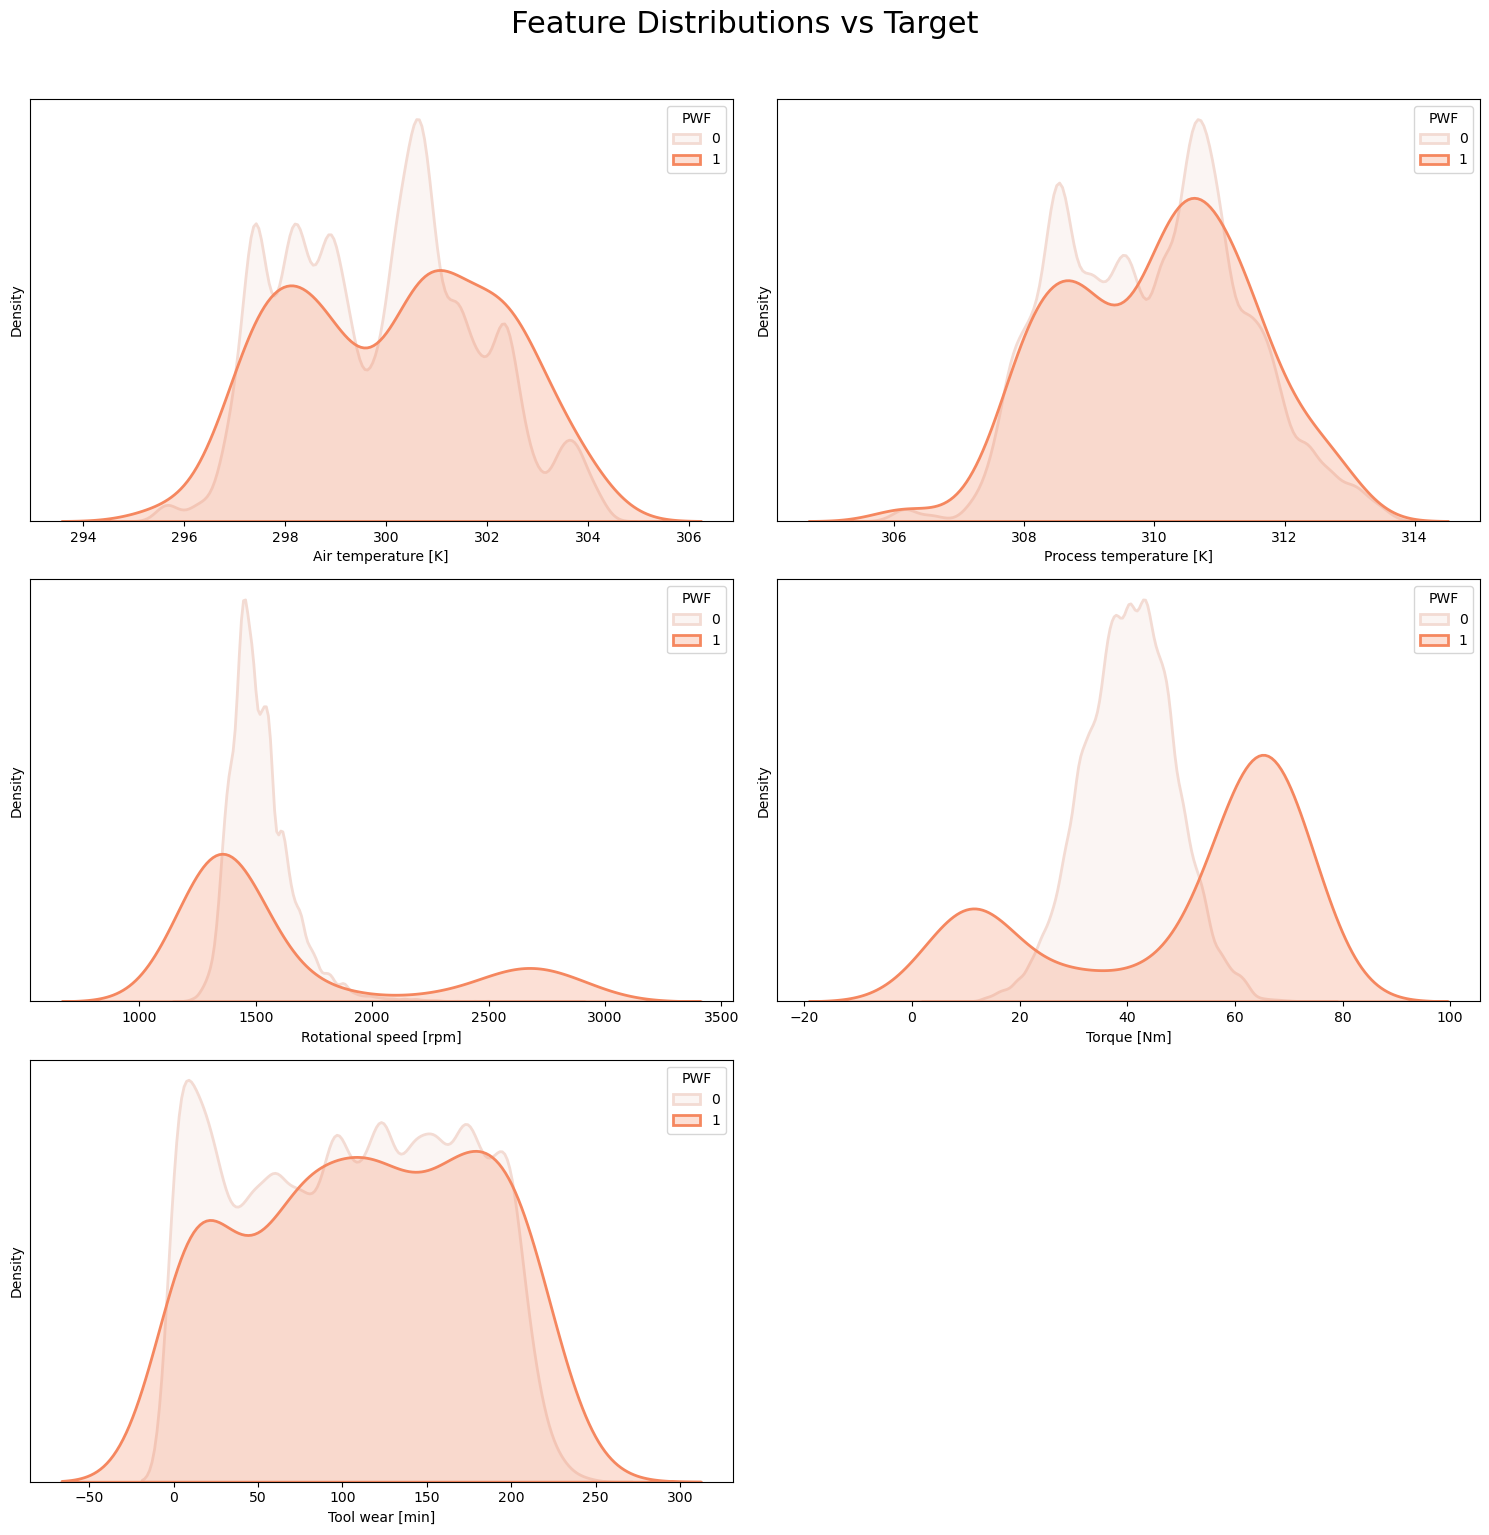

In [128]:
plot_kde_distribution(df_train, numeric, 'PWF', 2)

From the KDE plot, it's evident that the main features influencing PWF are 'Torque [Nm]' and 'Rotational speed [rpm]'. Considering the fundamentals of mechanical systems, power is derived from the product of torque and rotational speed. Therefore, I've introduced a new feature, 'Power', calculated as:
Power= Torque [Nm]× Rotational speed [rpm]

This will be used to further investigate its correlation with PWF

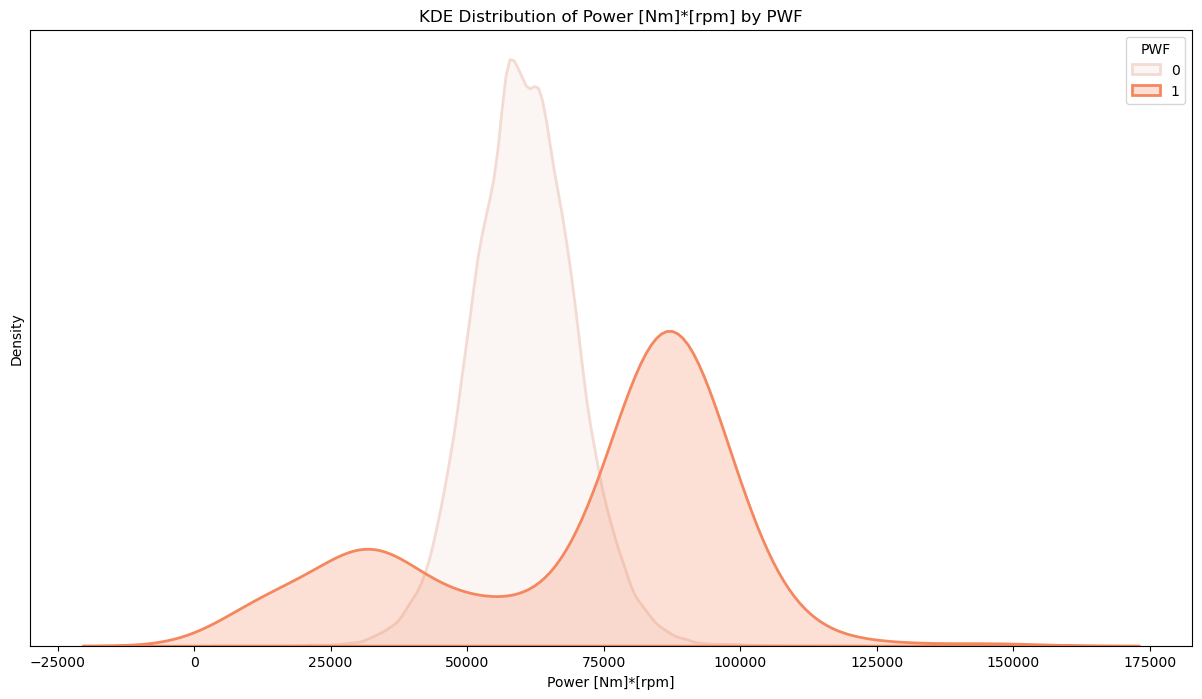

In [129]:
df_train['Power [Nm]*[rpm]'] = df_train['Torque [Nm]'] * df_train['Rotational speed [rpm]']
df_test['Power [Nm]*[rpm]'] = df_test['Torque [Nm]'] * df_test['Rotational speed [rpm]']
df_sub['Power [Nm]*[rpm]'] = df_sub['Torque [Nm]'] * df_sub['Rotational speed [rpm]']

plot_single_kde(df_train, 'Power [Nm]*[rpm]', 'PWF')

It's evident from the KDE distribution that the new feature significantly differentiates between machines with PWF and those without. Thus, our speculation appears to be accurate.

### Overstrain Failure

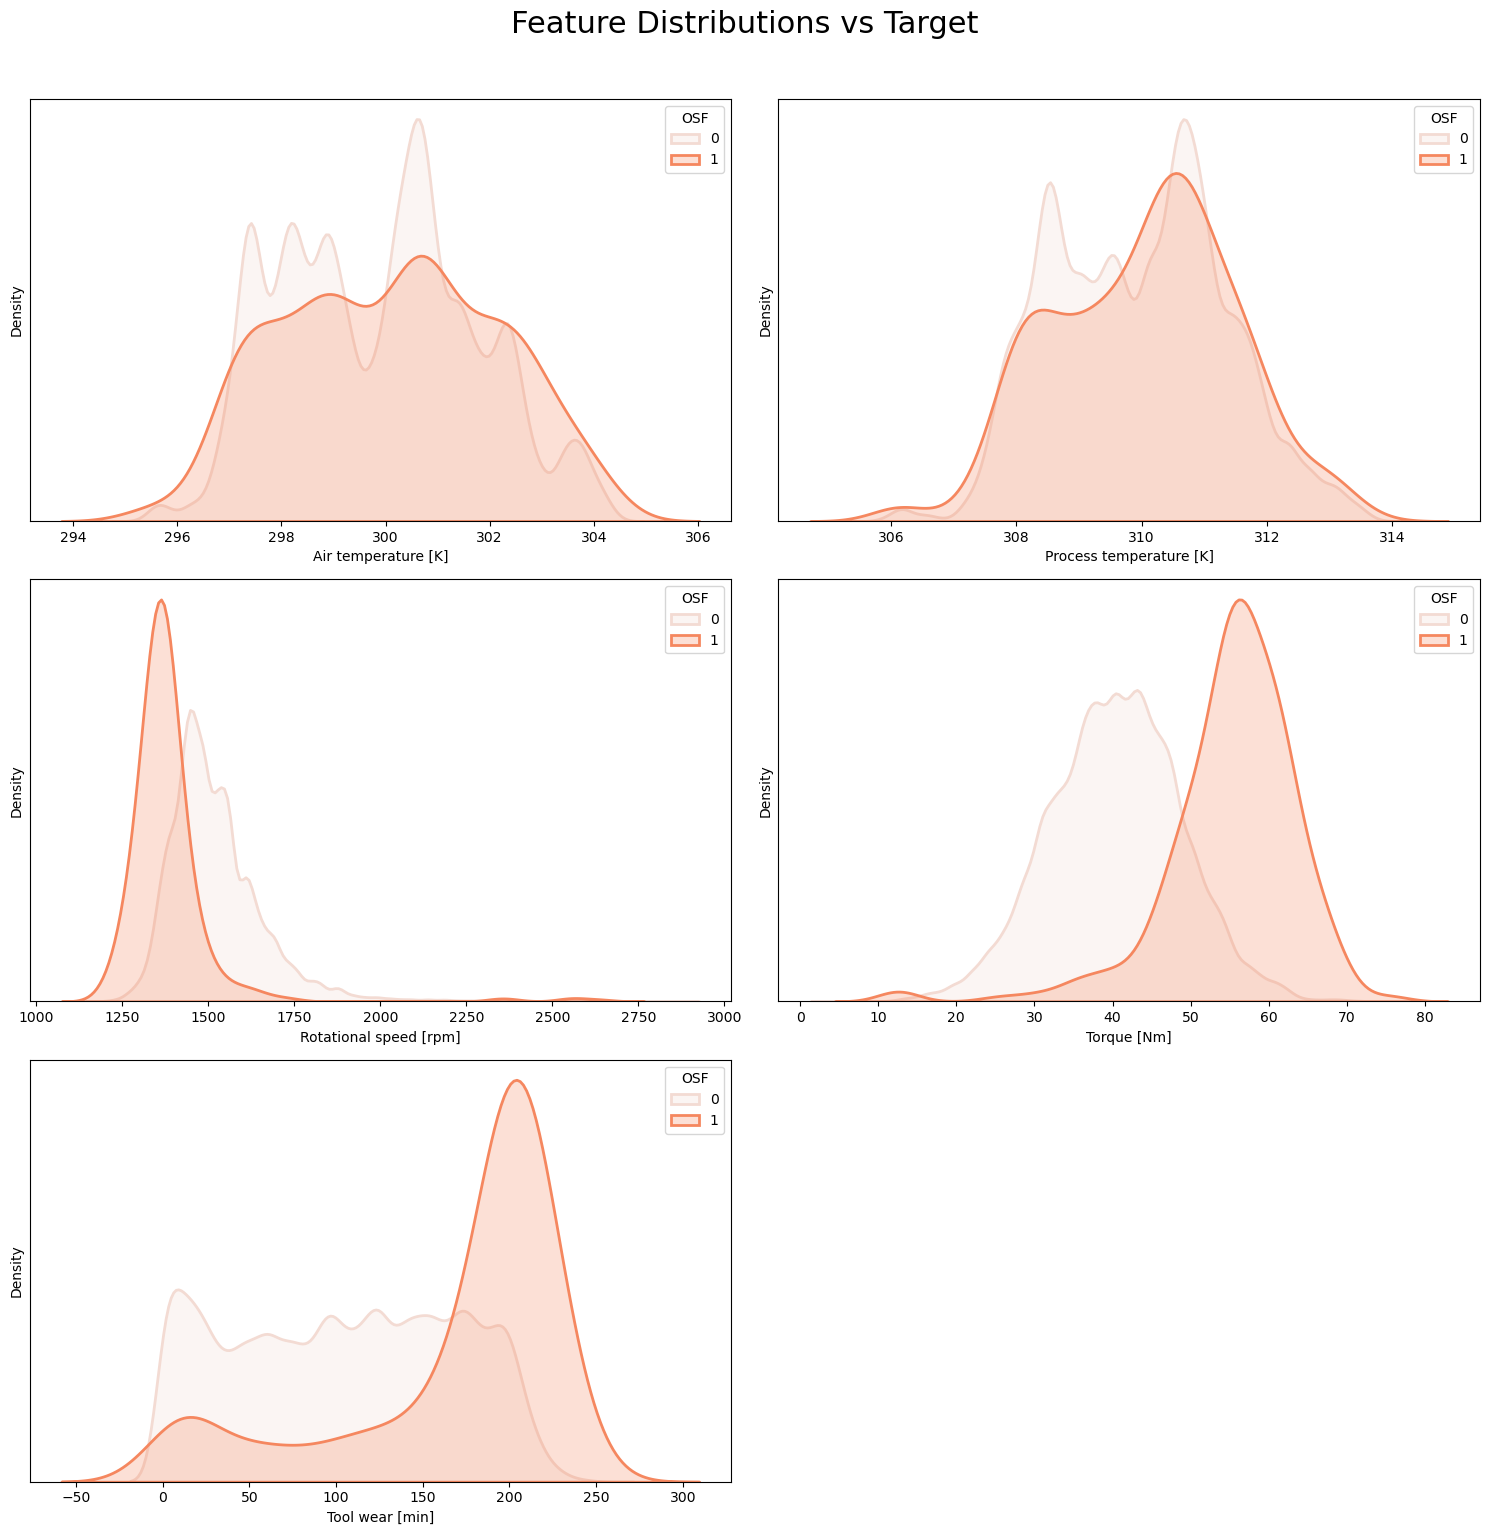

In [130]:
plot_kde_distribution(df_train, numeric, 'OSF', 2)

From the KDE plot, we observe that 'Torque [Nm]' and 'Tool wear [min]' are significant factors influencing OSF. It's plausible to think that as the torque applied increases, it could accelerate the rate of tool wear. Inversely, as tools wear out over time, they might require more torque to achieve the same operation. Given this potential synergistic relationship, we've created a new interaction feature, 'Torque_Tool_Wear', calculated as:

Torque_Toll_Wear = Torque [Nm] * Tool wear [min]

This new feature aims to encapsulate the combined effect of torque and tool wear on OSF and to better understand their intertwined impact.

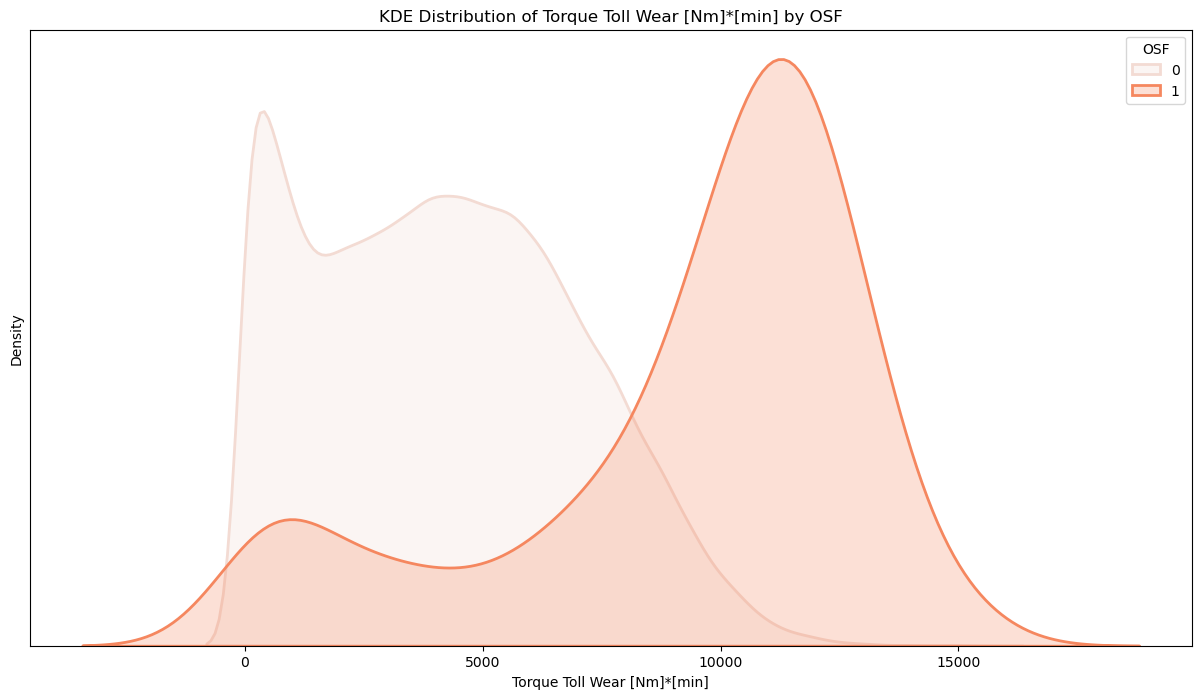

In [131]:
df_train['Torque Toll Wear [Nm]*[min]'] = df_train['Torque [Nm]'] * df_train['Tool wear [min]']
df_test['Torque Toll Wear [Nm]*[min]'] = df_test['Torque [Nm]'] * df_test['Tool wear [min]']
df_sub['Torque Toll Wear [Nm]*[min]'] = df_sub['Torque [Nm]'] * df_sub['Tool wear [min]']

plot_single_kde(df_train, 'Torque Toll Wear [Nm]*[min]', 'OSF')

It's evident from the KDE distribution that the new feature significantly differentiates between machines with OSF and those without. Thus, our speculation appears to be accurate.

### Random Failure

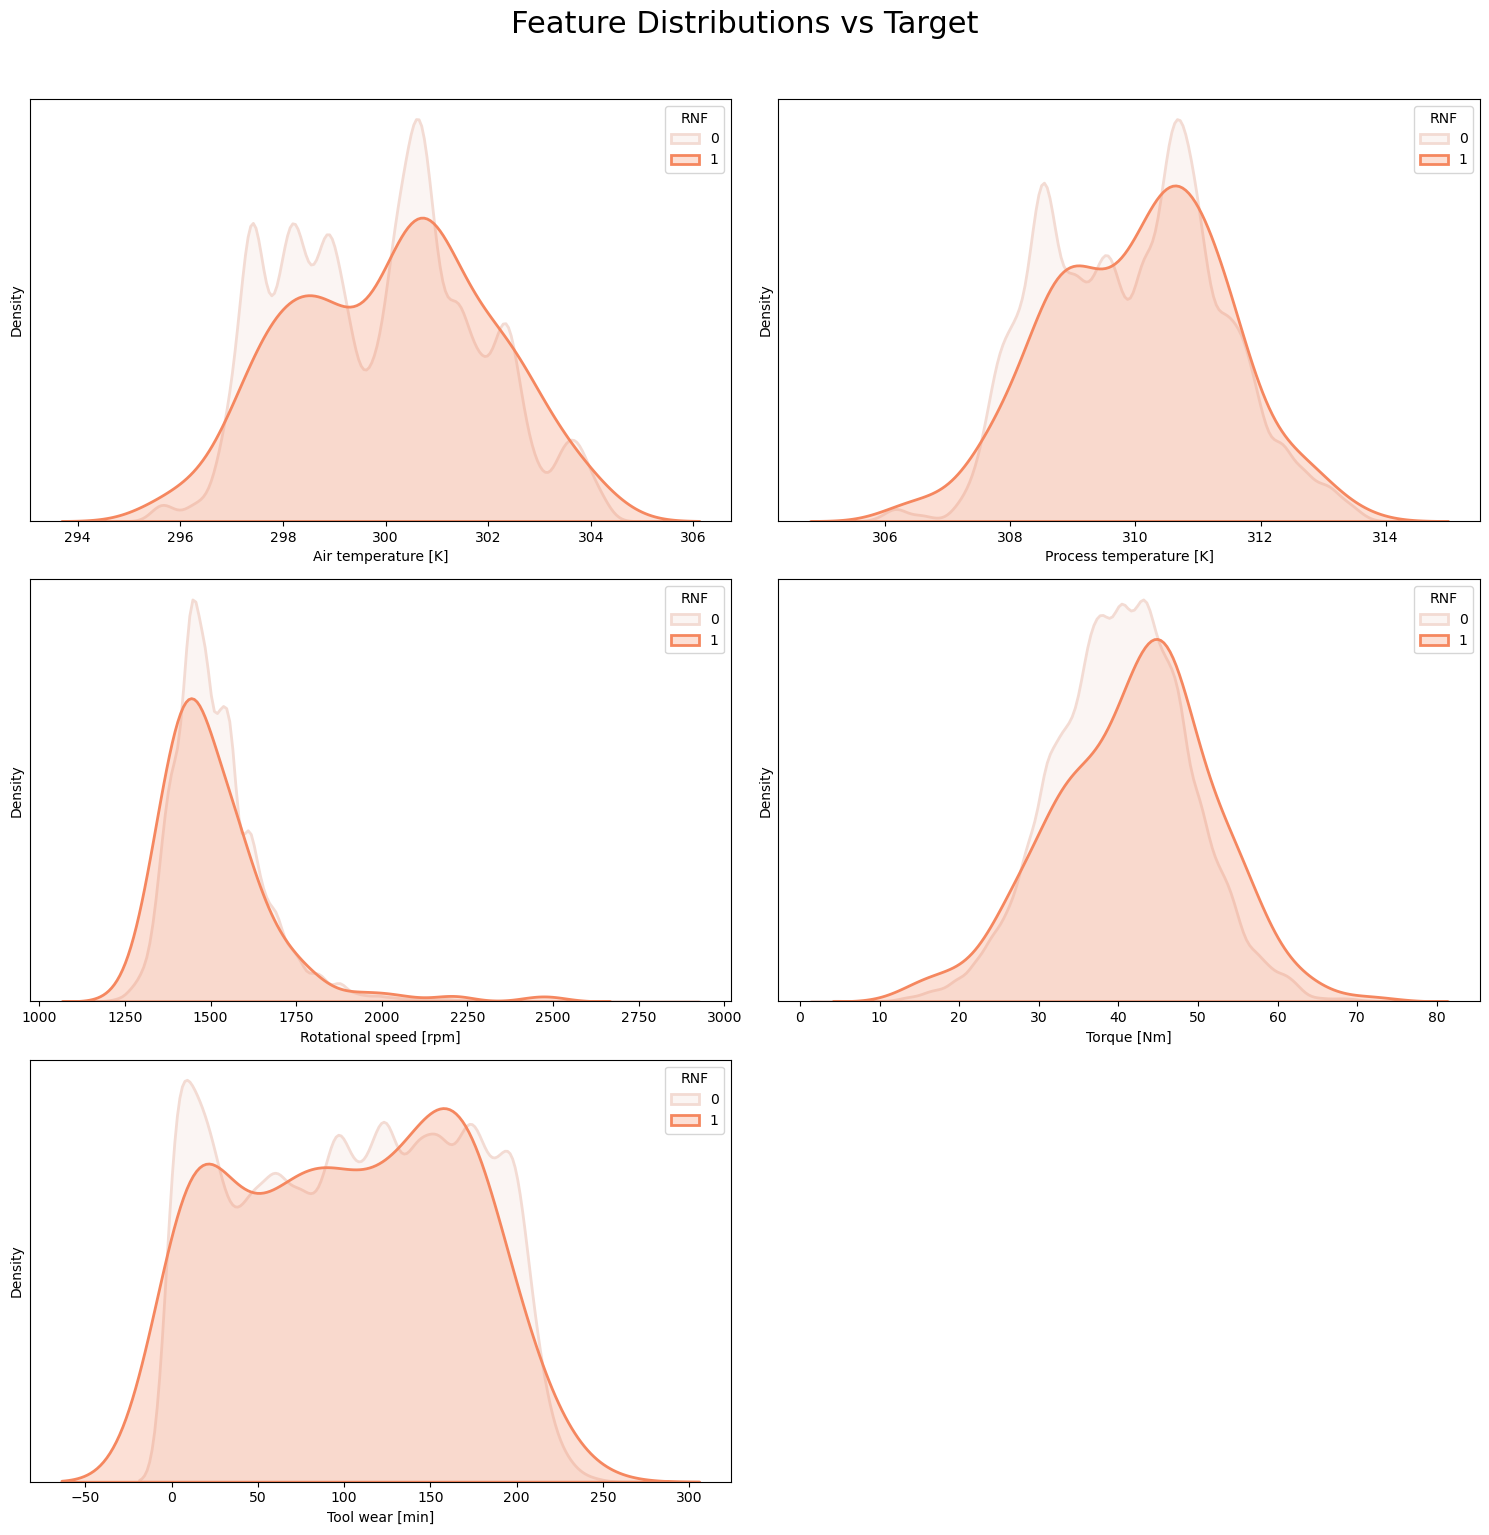

In [132]:
plot_kde_distribution(df_train, numeric, 'RNF', 2)

We observe that no feature exhibits a significant difference in the KDE distribution for machines with a random failure mode.

# Data Preprocessed

## Outliers

From the previous box plot, it is evident that there are outliers present in both 'Rotational speed [rpm]' and 'Torque [Nm]', especially in 'Rotational speed'. When building a predictive model, such outliers can adversely affect its ability to predict general scenarios."

In [133]:
print('A reasonable amount of data to remove is approximately', int(len(df_train) * 0.05), 'data points.')

A reasonable amount of data to remove is approximately 5457 data points.


### Rotational Speed [rpm]

In [134]:
print('Number of outlier data points for Rotational speed [rpm]:', count_outliers(df_train, 'Rotational speed [rpm]', 0.25, 0.75))
print('Range within which outliers lie for Rotational speed [rpm]:', range_outliers(df_train, 'Rotational speed [rpm]', 0.25, 0.75))

Number of outlier data points for Rotational speed [rpm]: 4156
Range within which outliers lie for Rotational speed [rpm]: (1432.0, 148.0, 1580.0)


### Torque [Nm]

In [135]:
print('Number of outlier data points for Torque [Nm]:', count_outliers(df_train, 'Torque [Nm]', 0.25, 0.75))
print('Range within which outliers lie for Torque [Nm]:', range_outliers(df_train, 'Torque [Nm]', 0.25, 0.75))

Number of outlier data points for Torque [Nm]: 845
Range within which outliers lie for Torque [Nm]: (34.6, 11.5, 46.1)


The number of outlier data points for 'Rotational speed [rpm]' and 'Torque [Nm]' totals 5,001. This falls within our acceptable limit for data removal, so we can safely exclude these data points.

In [136]:
df_train_cleaned = remove_outliers(df_train, 'Rotational speed [rpm]')
df_train_cleaned = remove_outliers(df_train_cleaned, 'Torque [Nm]')

In [137]:
print('Total number of data points removed:', len(df_train) - len(df_train_cleaned))

Total number of data points removed: 4684


## Encode Categorical Variables

In [138]:
df_train_cleaned.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Temperature difference [K],Power [Nm]*[rpm],Torque Toll Wear [Nm]*[min]
72862,M23672,M,297.2,308.4,1498,36.8,101,0,0,0,0,0,0,-11.2,55126.4,3716.8
81454,M17107,M,299.2,308.4,1378,48.5,195,0,0,0,0,0,0,-9.2,66833.0,9457.5
134753,L51381,L,302.4,311.0,1381,50.3,203,0,0,0,0,0,0,-8.6,69464.3,10210.9
60614,L56493,L,298.5,309.4,1546,36.0,170,0,0,0,0,0,0,-10.9,55656.0,6120.0
92513,L55014,L,300.0,311.4,1462,46.4,187,0,0,0,0,0,0,-11.4,67836.8,8676.8


In [139]:
encoder = OneHotEncoder(sparse=False)
encoder = OneHotEncoder(sparse=False)

encoded_train = encoder.fit_transform(df_train_cleaned[['Type']])
encoded_columns = [f"Type_{cat}" for cat in encoder.categories_[0]]
print("Encoder Categories:", encoder.categories_[0])

df_train_cleaned = df_train_cleaned.drop('Type', axis=1)
for i, col in enumerate(encoded_columns):
    df_train_cleaned[col] = encoded_train[:, i]

encoded_test = encoder.transform(df_test[['Type']])

df_test = df_test.drop('Type', axis=1)
for i, col in enumerate(encoded_columns):
    df_test[col] = encoded_test[:, i]

encoded_sub = encoder.transform(df_sub[['Type']])

df_sub = df_sub.drop('Type', axis=1)
for i, col in enumerate(encoded_columns):
    df_sub[col] = encoded_sub[:, i]

Encoder Categories: ['H' 'L' 'M']


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [140]:
df_train_cleaned = df_train_cleaned.drop('Product ID', axis=1)

In [141]:
df_test = df_test.drop('Product ID', axis=1)
df_sub = df_sub.drop('Product ID', axis=1)

In [142]:
df_train.to_csv('Plot.csv', index=False)

# Feature Engineernig

In addition to the original numerical features, we have introduced new attributes such as 'Temperature difference [K]', 'Power', and 'Torque_Tool_Wear'. These have been identified to significantly influence certain failure modes, which in turn affect machine performance.

Subsequently, we present KDE plots of these features. While the KDE plots might suggest that the distribution patterns of some features (in terms of differentiating between failed and non-failed machines) aren't substantially distinct, this doesn't inherently imply these features are inconsequential for predictions. It's crucial to remember that the KDE plots do not account for feature interactions.

As an initial step, we'll incorporate these features into our machine learning model and assess the results. Further insights can be garnered by examining feature importance and SHAP values, allowing for a deeper understanding of how each feature contributes to failure predictions.

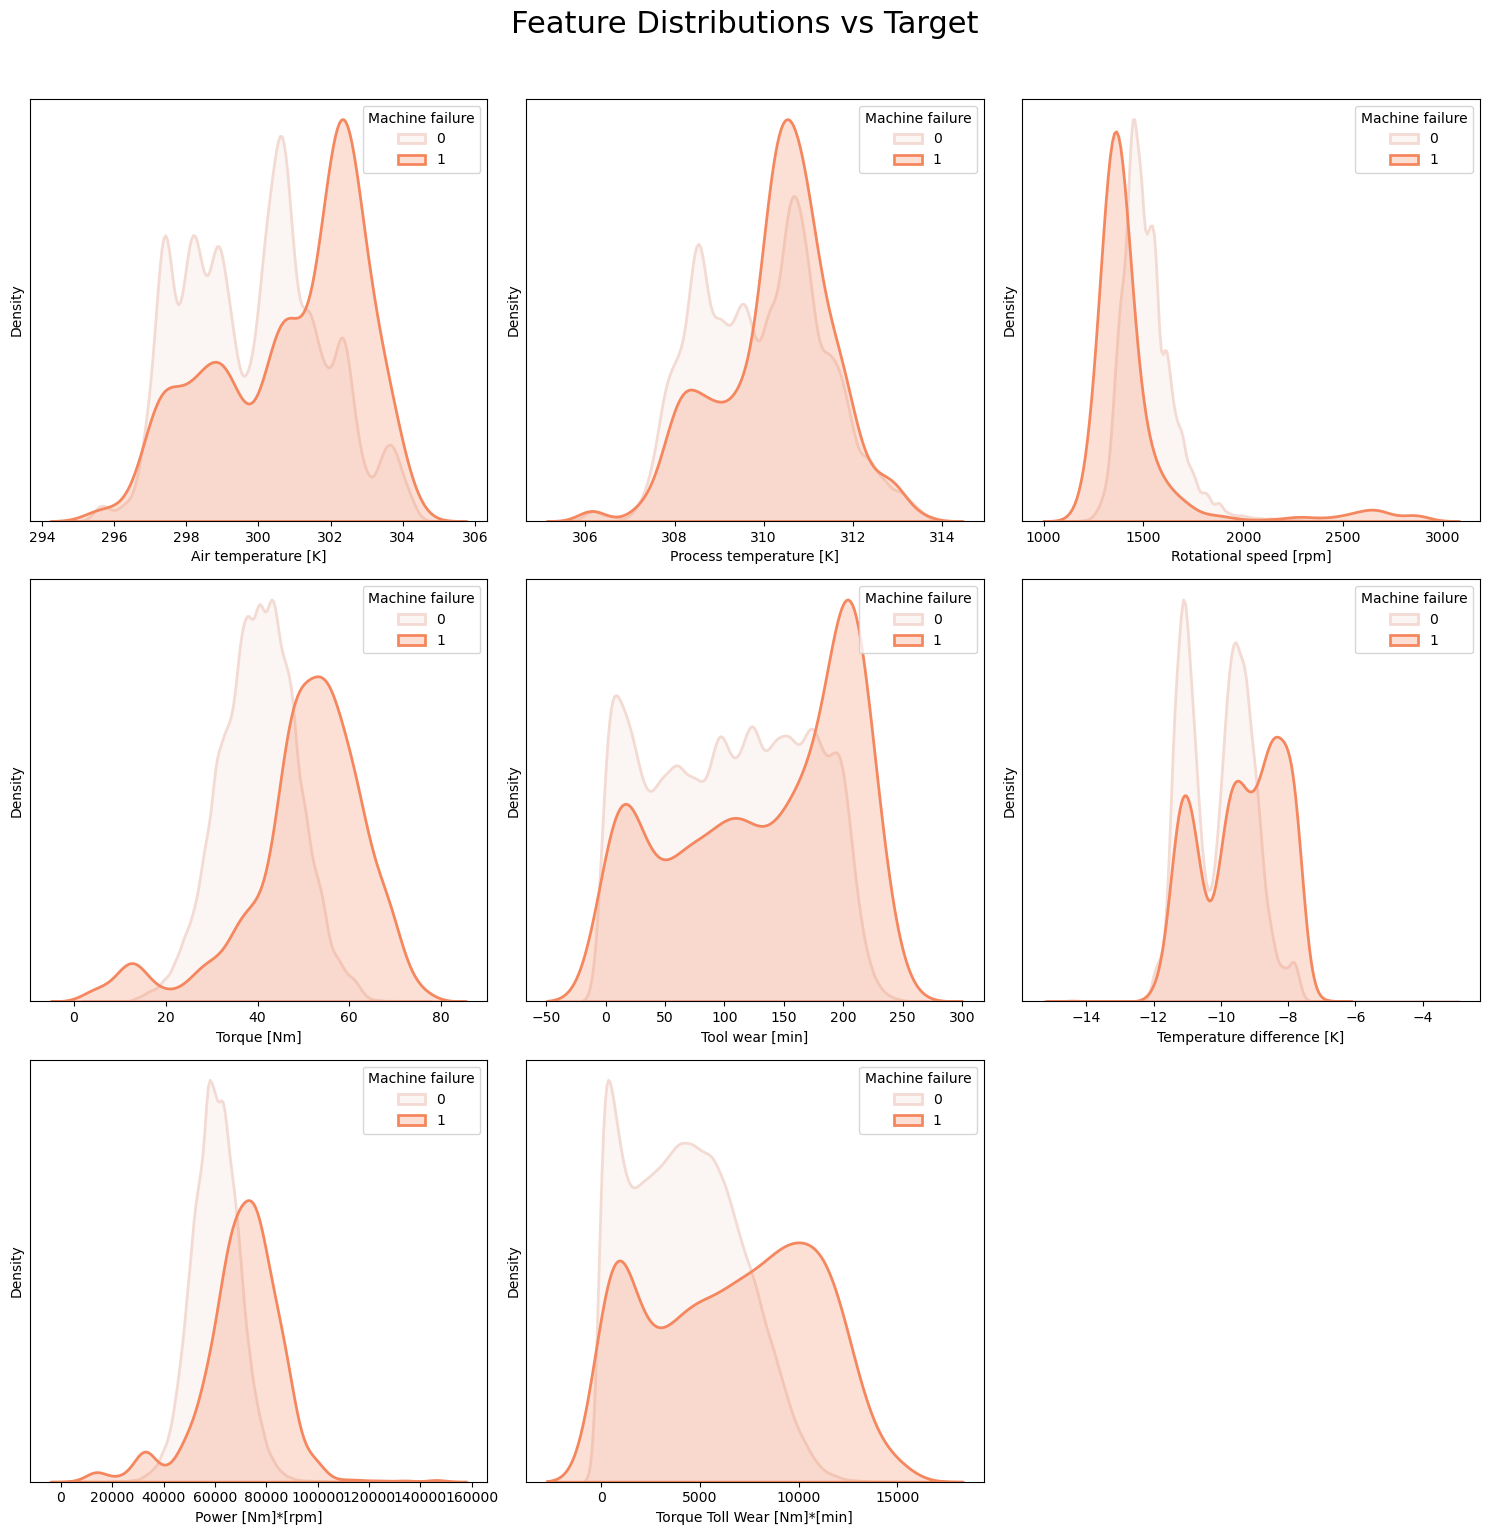

In [143]:
features = numeric + ['Temperature difference [K]', 'Power [Nm]*[rpm]', 'Torque Toll Wear [Nm]*[min]']

plot_kde_distribution(df_train, features, 'Machine failure', 3)

In [144]:
df_train_cleaned.head(1)

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Temperature difference [K],Power [Nm]*[rpm],Torque Toll Wear [Nm]*[min],Type_H,Type_L,Type_M
72862,297.2,308.4,1498,36.8,101,0,0,0,0,0,0,-11.2,55126.4,3716.8,0.0,0.0,1.0


In [145]:
df_test.head(1)

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Temperature difference [K],Power [Nm]*[rpm],Torque Toll Wear [Nm]*[min],Type_H,Type_L,Type_M
108143,303.3,311.2,1619,31.1,219,0,0,0,0,0,0,-7.9,50350.9,6810.9,0.0,1.0,0.0


# Model Selection and Feature Selection

## Evaluation Function

In [146]:
def plot_roc_auc(model, X, Y):
    Y_prob = model.predict_proba(X)[:, 1]

    fpr, tpr, _ = roc_curve(Y, Y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    print("AUC Score: ", roc_auc)

In [147]:
def evaluate_and_plot_cm(model, X, Y, dataset_type, threshold=0.5):
    y_probs = model.predict_proba(X)[:, 1]

    y_pred = (y_probs >= threshold).astype(int)

    cm = confusion_matrix(Y, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {dataset_type} set (Threshold: {threshold:.2f})')
    plt.show()

    print(f"Classification report for {dataset_type} set")
    print("-------------------------------------------------------")
    print(classification_report(Y, y_pred, zero_division=1))

In [148]:
def plot_feature_importances(importances, feature_names):

    importance_df = pd.DataFrame({'features': feature_names, 'importance': importances})

    importance_df = importance_df.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10,8))
    plt.barh(importance_df['features'], importance_df['importance'], color='skyblue')
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.title('Feature Importances', fontsize=16)
    plt.gca().invert_yaxis()  # Reverse the order to have the most important at the top
    plt.show()

## XGBoost 

In [149]:
df_train_cleaned.columns = [col.replace("[", "").replace("]", "").replace("<", "") for col in df_train_cleaned.columns]
df_test.columns = [col.replace("[", "").replace("]", "").replace("<", "") for col in df_test.columns]
df_sub.columns = [col.replace("[", "").replace("]", "").replace("<", "") for col in df_sub.columns]

In [150]:
X_train, y_train = df_train_cleaned.drop('Machine failure', axis=1), df_train_cleaned['Machine failure']

In [151]:
# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 5, 7],
#     'n_estimators': [100, 200, 300],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.2, 0.5, 0.8],
#     'scale_pos_weight': [sum(y_train == 0) / sum(y_train == 1)]
# }

# xgb_clf = xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss')

# grid_search = GridSearchCV(xgb_clf, param_grid, scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)  
# grid_search.fit(X_train, y_train)

# print("Best parameters found: ", grid_search.best_params_)
# print("Highest AUC: ", grid_search.best_score_)

# best_xgb_model = grid_search.best_estimator_


Best parameters found:  {'colsample_bytree': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'scale_pos_weight': 74.3129055515501, 'subsample': 0.8}
Highest AUC:  0.9639288683439403

In [152]:
params_opt_xgb = {'colsample_bytree': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 
                  'scale_pos_weight': 74.3129055515501, 'subsample': 0.8}

best_xgb_model = xgb.XGBClassifier(**params_opt_xgb, objective='binary:logistic', 
                                      random_state=42, eval_metric='logloss')

best_xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [153]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
roc_auc_scores = cross_val_score(best_xgb_model, X_train, y_train, scoring='roc_auc', cv=5)

# Display the individual ROC AUC scores
print("ROC AUC scores for each fold:")
print(roc_auc_scores)

# Display the average and standard deviation of the ROC AUC scores
print("Average ROC AUC score:", roc_auc_scores.mean())
print("Standard deviation:", roc_auc_scores.std())

ROC AUC scores for each fold:
[0.97427358 0.9713721  0.95693435 0.94901375 0.96904727]
Average ROC AUC score: 0.9641282077799869
Standard deviation: 0.009589558251045868


In [154]:
importance_df = pd.DataFrame({'features': X_train.columns, 'importance': best_xgb_model.feature_importances_})

importance_df = importance_df.sort_values(by='importance', ascending=False)

In [155]:
importance_df.to_csv('importance_df.csv', index=False)

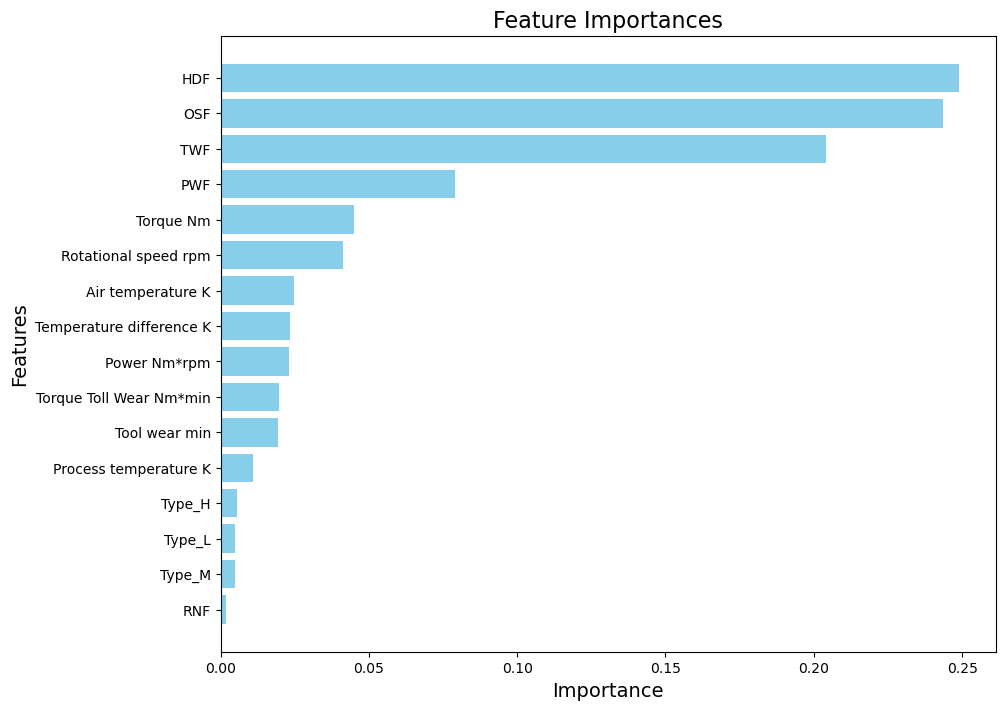

In [156]:
plot_feature_importances(best_xgb_model.feature_importances_, X_train.columns)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Text(0.5, 1.0, 'Feature Importance - Dot')

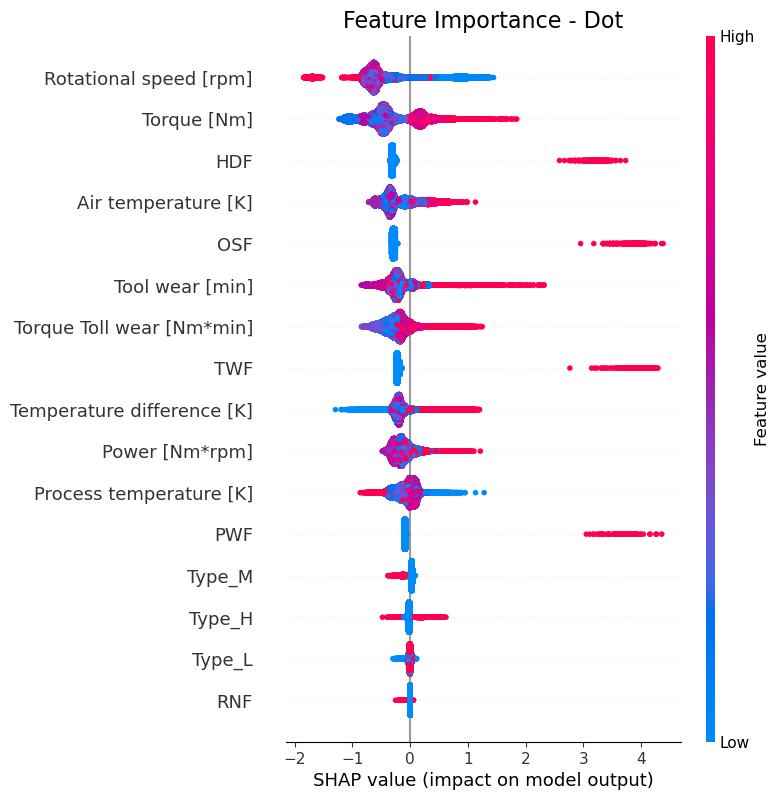

In [157]:
explainer = shap.TreeExplainer(best_xgb_model)

shap_values = explainer.shap_values(X_train)

col_name = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
            'Tool wear [min]', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Temperature difference [K]',
            'Power [Nm*rpm]', 'Torque Toll wear [Nm*min]', 'Type_H', 'Type_L', 'Type_M']

X_train.columns = col_name

plt.figure(figsize=(20, 14))
shap.summary_plot(shap_values, X_train, plot_type="dot", show=False)
plt.savefig('SHAP.png')
plt.title("Feature Importance - Dot", fontsize=16)


Based on our feature importance and SHAP value analyses, the features ['Type_H', 'Type_L', 'Type_M', 'RNF', 'Process temperature K'] appear to have limited significance in predicting the outcome. Consequently, we've decided to exclude these features and retrain the model. This will allow us to assess the performance of the refined model.

In [86]:
removed_features = ['Type_H', 'Type_L', 'Type_M', 'RNF', 'Process temperature K']
selected_features = X_train.columns.to_list()

for feature in removed_features:
    selected_features.remove(feature)

X_train_selected = X_train[selected_features]
X_train_selected.head(1)

,Air temperature K,Rotational speed rpm,Torque Nm,Tool wear min,TWF,HDF,PWF,OSF,Temperature difference K,Power Nm*rpm,Torque Toll Wear Nm*min
72862,297.2,1498,36.8,101,0,0,0,0,-11.2,55126.4,3716.8


In [87]:
params_opt_xgb = {'colsample_bytree': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 
                  'scale_pos_weight': 74.3129055515501, 'subsample': 0.8}

best_xgb_selected = xgb.XGBClassifier(**params_opt_xgb, objective='binary:logistic', 
                                      random_state=42, eval_metric='logloss')

best_xgb_selected.fit(X_train_selected, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [88]:
roc_auc_scores = cross_val_score(best_xgb_selected, X_train_selected, y_train, scoring='roc_auc', cv=5)

print("ROC AUC scores for each fold:")
print(roc_auc_scores)

print("Average ROC AUC score:", roc_auc_scores.mean())
print("Standard deviation:", roc_auc_scores.std())

ROC AUC scores for each fold:
[0.9678302  0.96874625 0.95462276 0.9507645  0.96724747]
Average ROC AUC score: 0.9618422345700474
Standard deviation: 0.007583861930966142


Both the original model and the refined model, which utilizes only selected features, achieved an ROC_AUC score of approximately 0.96. This is commendable performance. Given that a simpler model enhances our ability to interpret the data and is more adaptable to varied situations, we have chosen to move forward with the refined model.

In [89]:
X_train_selected

,Air temperature K,Rotational speed rpm,Torque Nm,Tool wear min,TWF,HDF,PWF,OSF,Temperature difference K,Power Nm*rpm,Torque Toll Wear Nm*min
72862,297.2,1498,36.8,101,0,0,0,0,-11.2,55126.4,3716.8
81454,299.2,1378,48.5,195,0,0,0,0,-9.2,66833.0,9457.5
134753,302.4,1381,50.3,203,0,0,0,0,-8.6,69464.3,10210.9
60614,298.5,1546,36.0,170,0,0,0,0,-10.9,55656.0,6120.0
92513,300.0,1462,46.4,187,0,0,0,0,-11.4,67836.8,8676.8
...,...,...,...,...,...,...,...,...,...,...,...
53994,297.9,1544,34.6,212,0,0,0,0,-9.6,53422.4,7335.2
38800,298.1,1588,38.7,27,0,0,0,0,-9.8,61455.6,1044.9
110887,297.4,1477,43.1,24,0,0,0,0,-10.8,63658.7,1034.4
23978,301.9,1465,47.3,47,0,0,0,0,-9.0,69294.5,2223.1


In [90]:
col_names=['Air temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF',
           'HDF', 'PWF', 'OSF', 'Temperature difference [K]', 'Power [Nm*rpm]', 'Torque Toll Wear [Nm*min]']

X_train_selected.columns = col_names

## Selected SHAP for Intepretation

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Text(0.5, 1.0, 'Feature Importance - Dot')

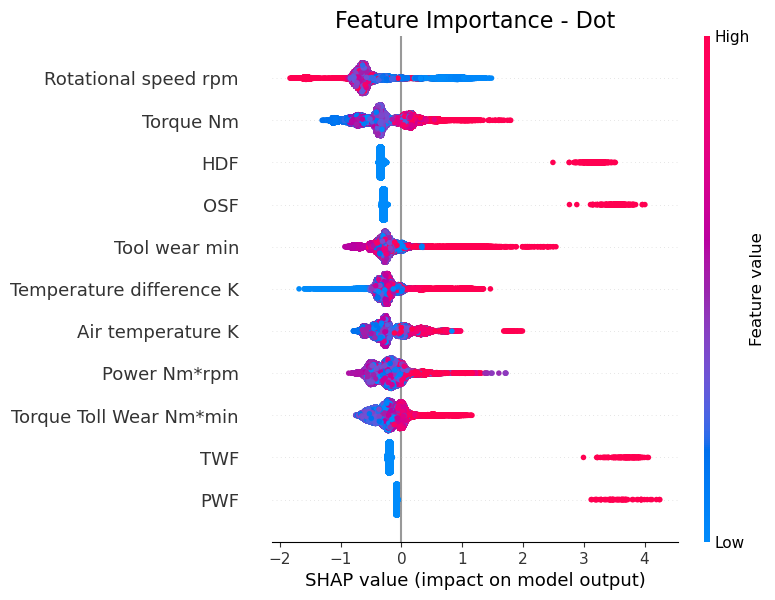

In [72]:
explainer = shap.TreeExplainer(best_xgb_selected)

shap_values = explainer.shap_values(X_train_selected)

plt.figure(figsize=(20, 14))

feature = ['Rotational speed [rpm]', 'Torque [Nm]', 'HDF', 'OSF', 'Tool wear [min]',
           'Temperature difference [K]', 'Air temperature [K]', 'Power [Nm*rpm]']
shap.summary_plot(shap_values, X_train_selected, plot_type="dot", show=False)


plt.title("Feature Importance - Dot", fontsize=16)

In [73]:
with open('shap_values.pkl', 'wb') as file:
    pickle.dump(shap_values, file)

The scatter plots of SHAP values against various feature values provide insights into how specific features influence the predictions. For instance, considering the 'Tool wear' feature, we observe a significant rise in SHAP values when the feature surpasses roughly 200. This implies, based on the model's interpretation, that if 'Tool wear' is effectively controlled below 200 minutes, it can considerably reduce the likelihood of machine failure.

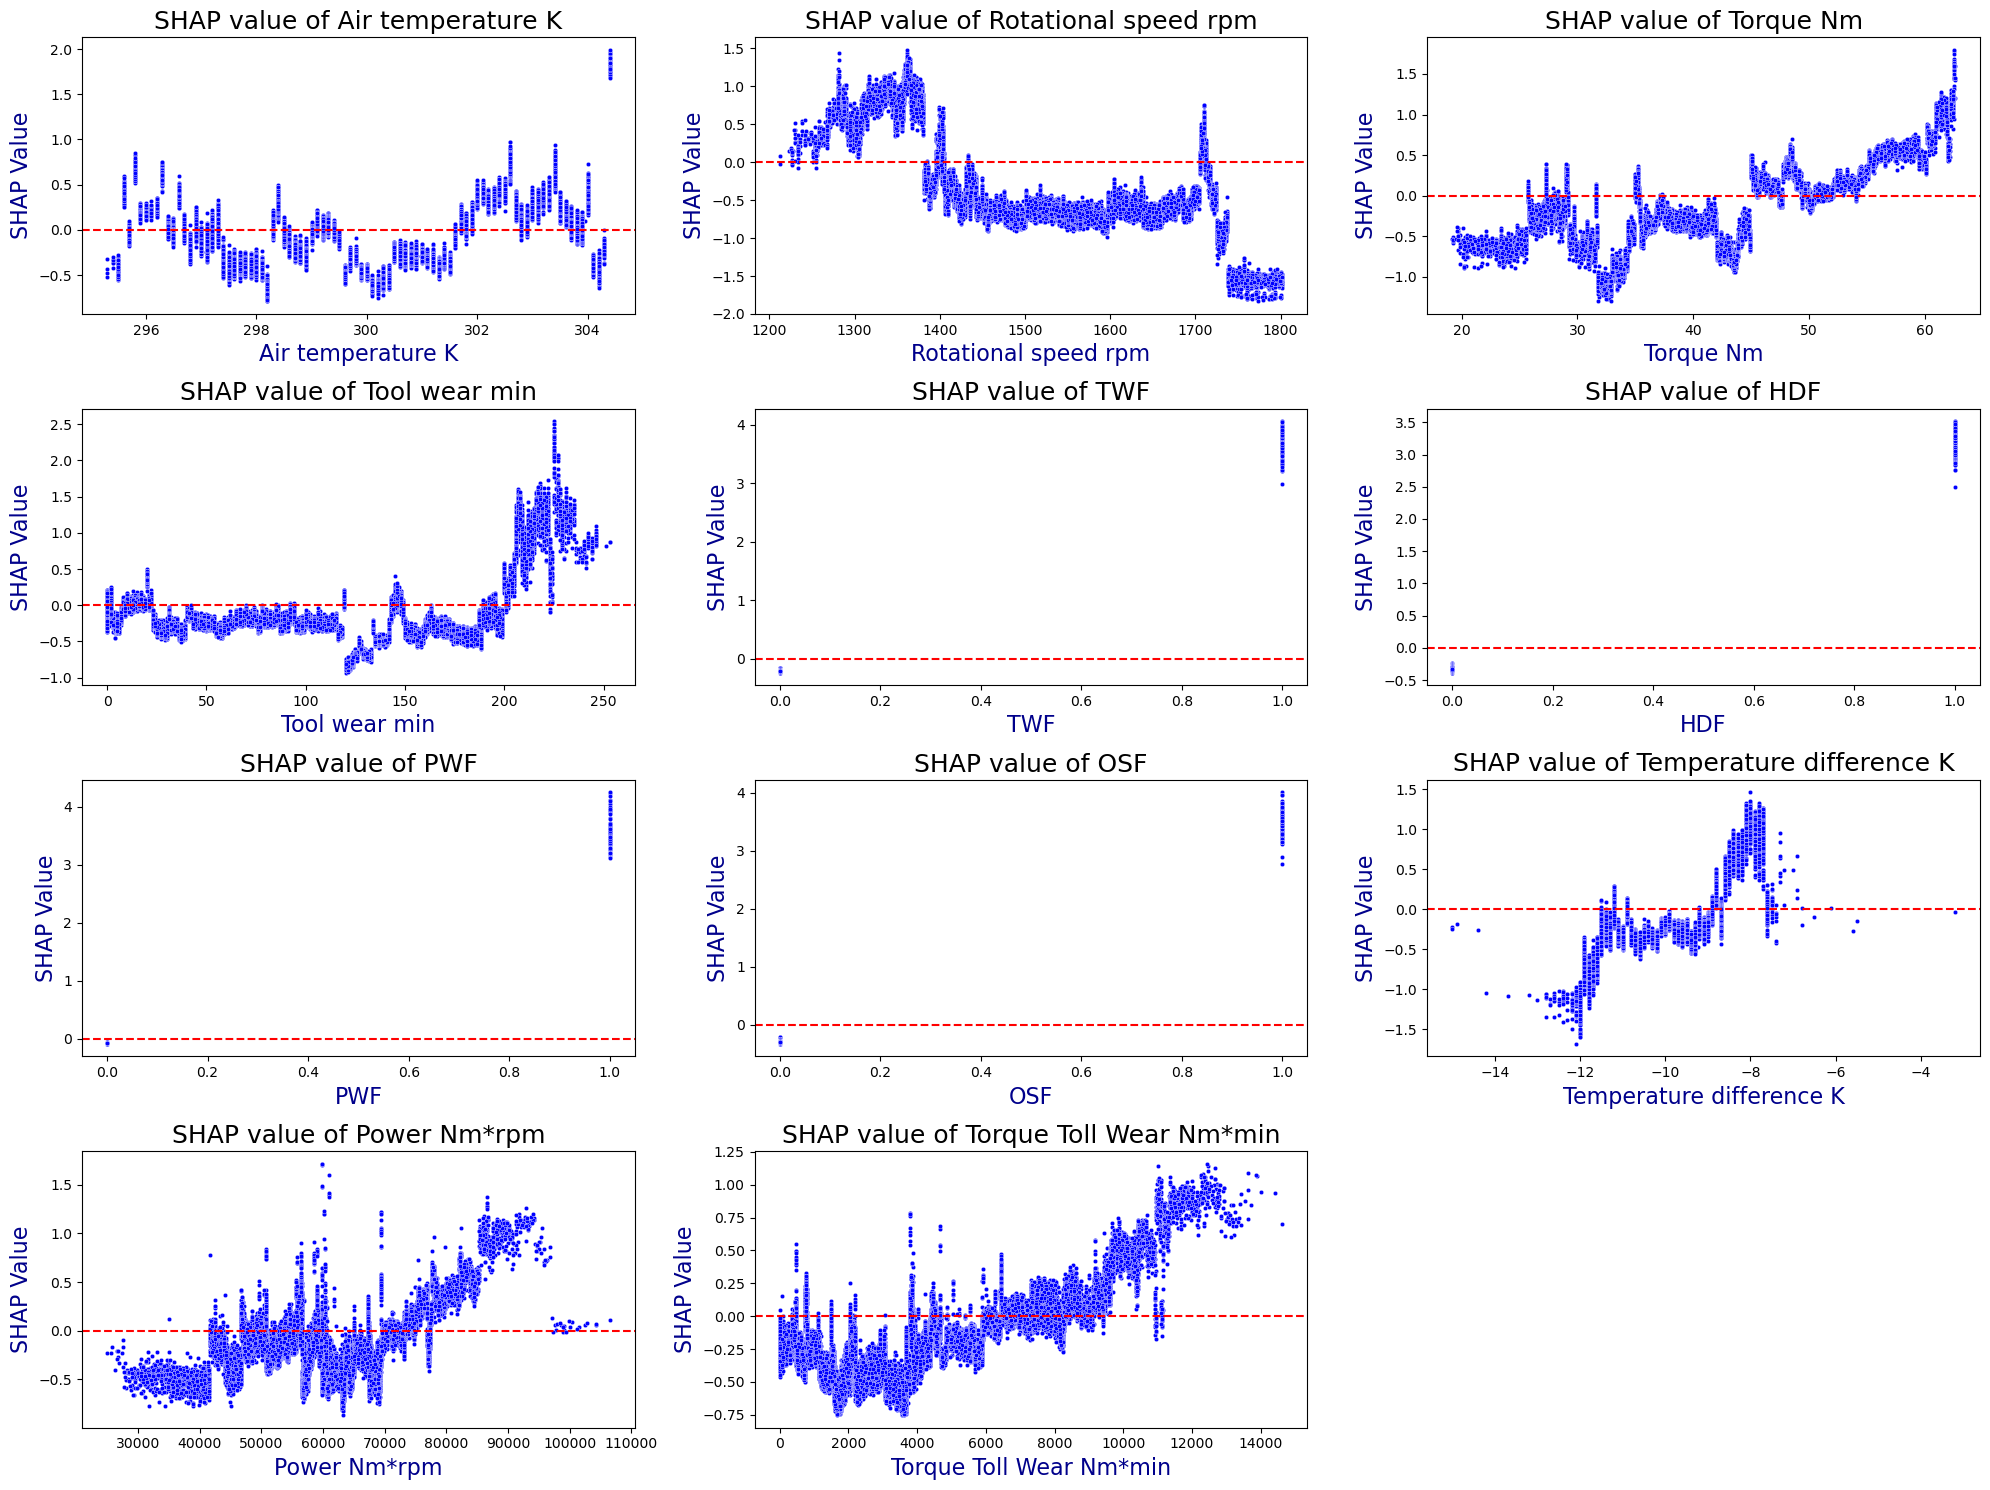

In [74]:
shap_df = pd.DataFrame(shap_values, columns=selected_features)

X_train_selected_reset = X_train_selected.reset_index(drop=True)
shap_df_reset = shap_df.reset_index(drop=True)

X_train_selected_reset.to_csv('SHAP_x.csv')
shap_df_reset.to_csv('SHAP_y.csv')

fig, axes = plt.subplots(4, 3, figsize=(20,15))

flattened_axes = axes.flatten()

for i, ax in enumerate(flattened_axes):
    if i < len(selected_features):
        
        sns.scatterplot(x=X_train_selected_reset[selected_features[i]],
                        y=shap_df_reset[selected_features[i]], color='blue', ax=ax, s=10)
        
        ax.axhline(0, color='red', linestyle='--')
        
        ax.set_title(f'SHAP value of {selected_features[i]}', fontsize=18)
        ax.set_xlabel(selected_features[i], fontsize=16, color='DarkBlue')
        ax.set_ylabel('SHAP Value', fontsize=16, color='DarkBlue')
    
    else:
        ax.axis('off')


plt.tight_layout()
plt.show()


## Validation

In [75]:
df_test, df_valid = train_test_split(df_test, test_size=0.5, stratify=df_test['Machine failure'], random_state=42)

In [76]:
X_valid, y_valid = df_valid.drop('Machine failure', axis=1), df_valid['Machine failure']
X_test, y_test = df_test.drop('Machine failure', axis=1), df_test['Machine failure']

In [77]:
X_valid_selected = X_valid[selected_features] 
X_test_selected = X_test[selected_features] 

In [78]:
best_xgb_selected = xgb.XGBClassifier(**params_opt_xgb, objective='binary:logistic', 
                                      random_state=42, eval_metric='logloss')

# Fit the model using early stopping
evals = [(X_train_selected, y_train), (X_valid_selected, y_valid)]
best_xgb_selected.fit(X_train_selected, y_train, eval_set=evals, early_stopping_rounds=100, verbose=50)

[0]	validation_0-logloss:0.67722	validation_1-logloss:0.67705


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[50]	validation_0-logloss:0.33777	validation_1-logloss:0.33632
[100]	validation_0-logloss:0.24177	validation_1-logloss:0.24216
[150]	validation_0-logloss:0.19818	validation_1-logloss:0.19920
[200]	validation_0-logloss:0.17047	validation_1-logloss:0.17184
[250]	validation_0-logloss:0.15098	validation_1-logloss:0.15301
[299]	validation_0-logloss:0.13672	validation_1-logloss:0.13938


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

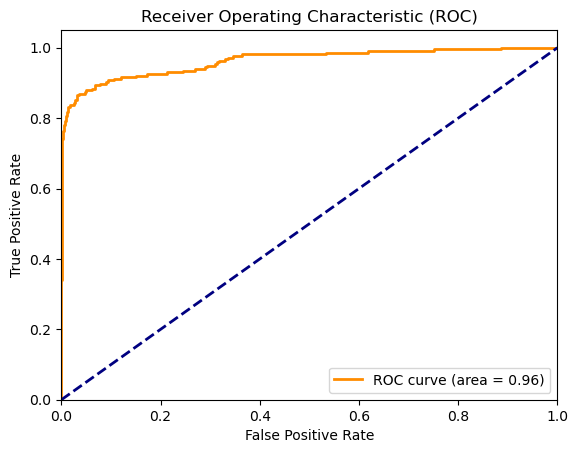

AUC Score:  0.9631104045001422


In [79]:
plot_roc_auc(best_xgb_selected, X_valid_selected, y_valid)

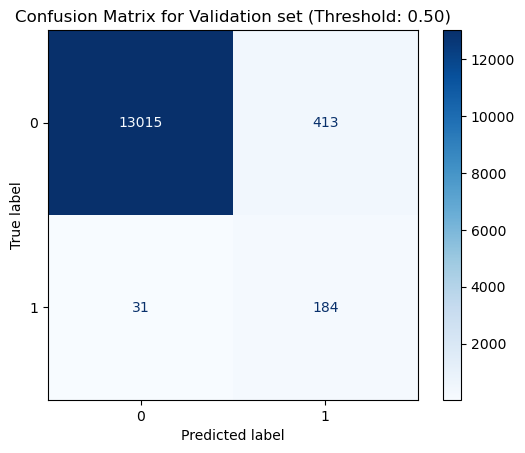

Classification report for Validation set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     13428
           1       0.31      0.86      0.45       215

    accuracy                           0.97     13643
   macro avg       0.65      0.91      0.72     13643
weighted avg       0.99      0.97      0.97     13643



In [80]:
evaluate_and_plot_cm(best_xgb_selected, X_valid_selected, y_valid, 'Validation')

## Test Set Evaluation

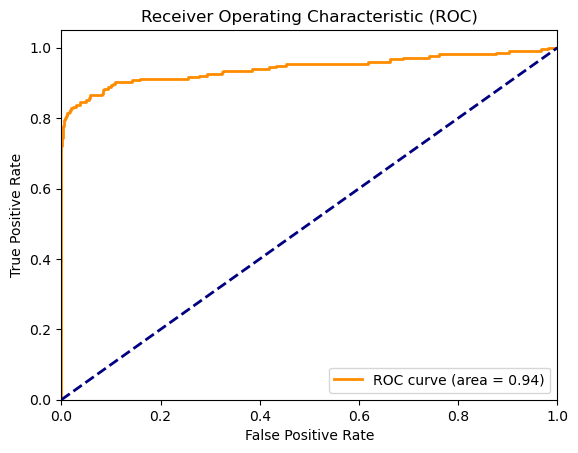

AUC Score:  0.9415899439560516


In [81]:
plot_roc_auc(best_xgb_selected, X_test_selected, y_test)

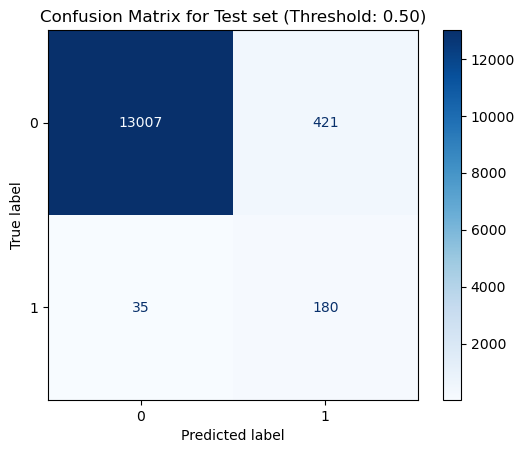

In [92]:
threshold = 0.5
model = best_xgb_selected
X = X_test_selected
Y = y_test
dataset_type = 'Test'

y_probs = model.predict_proba(X)[:, 1]

y_pred = (y_probs >= threshold).astype(int)

cm = confusion_matrix(Y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.savefig('ConfusionMatrix.png')
plt.title(f'Confusion Matrix for {dataset_type} set (Threshold: {threshold:.2f})')
plt.show()

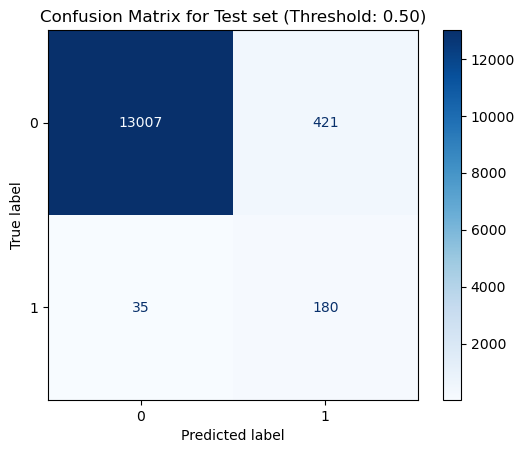

Classification report for Test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     13428
           1       0.30      0.84      0.44       215

    accuracy                           0.97     13643
   macro avg       0.65      0.90      0.71     13643
weighted avg       0.99      0.97      0.97     13643



In [82]:
evaluate_and_plot_cm(best_xgb_selected, X_test_selected, y_test, 'Test')

Based on our evaluation using the ROC_AUC score on the test set, we achieved a score of approximately 0.94. This is commendable, especially considering the extreme imbalance in the dataset.

Furthermore, examining the confusion matrix and classification report, we observe the following:



Given the nature of our data, these results are encouraging. It's noteworthy that while the precision for predicting failures (1) is 0.30, the recall is 0.84, which means the model identifies 84% of actual failures correctly, albeit with a higher false positive rate. Given the potential consequences of machine failure, prioritizing recall may be suitable for our use case, since it's essential to capture as many actual failures as possible.



# Submisson

In [83]:
df_sub

,id,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,TWF,HDF,PWF,OSF,RNF,Temperature difference K,Power Nm*rpm,Torque Toll Wear Nm*min,Type_H,Type_L,Type_M
0,136429,302.3,311.5,1499,38.0,60,0,0,0,0,0,-9.2,56962.0,2280.0,0.0,1.0,0.0
1,136430,301.7,311.0,1713,28.8,17,0,0,0,0,0,-9.3,49334.4,489.6,0.0,1.0,0.0
2,136431,301.3,310.4,1525,37.7,96,0,0,0,0,0,-9.1,57492.5,3619.2,0.0,1.0,0.0
3,136432,300.1,309.6,1479,47.6,5,0,0,0,0,0,-9.5,70400.4,238.0,0.0,0.0,1.0
4,136433,303.4,312.3,1515,41.3,114,0,0,0,0,0,-8.9,62569.5,4708.2,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90949,227378,302.3,311.4,1484,40.4,15,0,0,0,0,0,-9.1,59953.6,606.0,0.0,1.0,0.0
90950,227379,297.9,309.8,1542,33.8,31,0,0,0,0,0,-11.9,52119.6,1047.8,0.0,1.0,0.0
90951,227380,295.6,306.2,1501,41.4,187,0,0,0,0,0,-10.6,62141.4,7741.8,0.0,1.0,0.0
90952,227381,298.1,307.8,1534,40.3,69,0,0,0,0,0,-9.7,61820.2,2780.7,0.0,1.0,0.0


In [84]:
df_sub['Machine failure'] = best_xgb_selected.predict_proba(df_sub[selected_features])[:,1]

In [85]:
sub = df_sub[['id', 'Machine failure']]

In [86]:
sub.to_csv('submission.csv')